In [ ]:
from google.colab import drive
drive.mount('/content/drive')

root_path = '/content/drive/MyDrive/learning/nus/cs5260/project'
data_path = root_path + '/data'
best_model_path = root_path + '/best_models'
output_path = root_path + '/outputs'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
use_bert = True

# Feature Extraction
TODO:
1. Further clean spam emails that contain obvious content or metadata signaling that they are spam.

In [ ]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump, load
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
NO_EXPERIMENTS = 5

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Loop throught each csv file in the data folder
# Concat all dataframes into a single dataframe
# Create a new column called 'source' and store filename into it
# Save the dataframe to a new csv file in the data folder
dfs = []
for filename in os.listdir(data_path + '/cleaned'):
    if filename.endswith('kaggle.csv'):
        continue
    if filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(data_path + '/cleaned', filename))
        df.drop_duplicates(subset=['text', 'spam'], inplace=True)
        print(filename)
        print('Total:', df.shape[0], 'Non-spam:', df[df['spam'] == 0].shape[0], 'Spam:', df[df['spam'] == 1].shape[0])
        df['source'] = filename
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

assassin.csv
Total: 5757 Non-spam: 4203 Spam: 1554
enron.csv
Total: 28289 Non-spam: 14577 Spam: 13712
ling.csv
Total: 2840 Non-spam: 2374 Spam: 466


In [ ]:
duplicate_emails = df[df.duplicated(subset='text', keep=False)]
duplicate_emails.sort_values(by='text')

,text,original_text,spam,source


In [ ]:
duplicate_emails['source'].value_counts()

Series([], Name: count, dtype: int64)

In [ ]:
print('Before dropping duplicate emails:', df.shape[0])
df.drop_duplicates(subset=['text'], inplace=True)
print('After dropping duplicate emails:', df.shape[0])

Before dropping duplicate emails: 36886
After dropping duplicate emails: 36886


In [ ]:
df = df[~df['text'].str.contains('html body', na=False)]
df.shape

(36868, 4)

In [ ]:
df = df[~df['text'].isna()]
df.shape

(36868, 4)

In [ ]:
df['spam'].value_counts()

spam
0    21154
1    15714
Name: count, dtype: int64

In [ ]:
df.to_csv(os.path.join(data_path, 'preprocessed/raw_all.csv'), index=False)

In [ ]:
if use_bert:
    df = df[['original_text', 'spam']].copy()
    df.columns = ['text', 'spam']
else:
    df = df[['text', 'spam']].copy()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df['text'], df['spam'], test_size=0.1, random_state=42)

In [ ]:
df.shape, X_train.shape, X_val.shape

((36868, 2), (33181,), (3687,))

In [ ]:
y_val[y_val == 0].shape, y_val[y_val == 1].shape

((2165,), (1522,))

In [ ]:
vectorizer = TfidfVectorizer()
train_tfidf_matrix = vectorizer.fit_transform(X_train)
train_tfidf_df = pd.DataFrame(train_tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

dump(vectorizer, os.path.join(root_path, 'tfidf_vectorizer.joblib'))

['/content/drive/MyDrive/learning/nus/cs5260/project/tfidf_vectorizer.joblib']

# Datasets & Loaders

## TF-IDF

In [ ]:
class TFIDFDataset(Dataset):
    def __init__(self, features_df, labels_df):
        self.features = torch.tensor(features_df.to_numpy(), dtype=torch.float32)
        self.labels = torch.tensor(labels_df.to_numpy(), dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [ ]:
val_tfidf_df = pd.DataFrame(vectorizer.transform(X_val).toarray(), columns=vectorizer.get_feature_names_out())

In [ ]:
BATCH_SIZE = 256

train_loader = DataLoader(TFIDFDataset(train_tfidf_df, y_train), batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(TFIDFDataset(val_tfidf_df, y_val), batch_size=BATCH_SIZE, shuffle=False)

# Models

## MLPs

In [ ]:
class MLPBlock(nn.Module):
    def __init__(self, input_size, output_size, dropout_rate=0.5):
        super(MLPBlock, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = F.relu(self.linear(x))
        x = self.dropout(x)
        return x

class MLP(nn.Module):
    def __init__(self, input_size, neurons, best_model_path, dropout_rate=0.5, name=None):
        super(MLP, self).__init__()

        self.blocks = nn.ModuleList()
        self.name = f'mlp_{len(neurons) + 1}'
        if name is not None:
            self.name = name
        self.best_model_path = best_model_path

        # Create MLP blocks based on the 'neurons' list
        layer_sizes = [input_size] + neurons
        for i in range(1, len(layer_sizes)):
            block = MLPBlock(layer_sizes[i-1], layer_sizes[i], dropout_rate)
            self.blocks.append(block)

        # Output layer
        self.output = nn.Linear(layer_sizes[-1], 1)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        x = self.output(x)
        x = torch.sigmoid(x)  # Sigmoid activation to get probabilities
        return x

    def get_model_path(self, overrided_name=None):
        return os.path.join(self.best_model_path, overrided_name if overrided_name else self.name + '.pt')

    def load(self, overrided_name=None):
        self.load_state_dict(torch.load(self.get_model_path(overrided_name)))
        self.to(device)

    def save(self, overrided_name=None):
        torch.save(self.state_dict(), self.get_model_path(overrided_name))


In [ ]:
def compute_correct_predictions(y, logits):
    preds = logits >= 0.5
    correct_predictions = (preds == y).sum().item()
    return correct_predictions

def run_epoch(model, loader, attack=None, opt=None, description='', **kwargs):
    if opt is not None:
        description = "Training   " if description == '' else description
    else:
        description = "Validation " if description == '' else description

    criterion = nn.BCELoss(reduction='sum')

    total_loss = 0
    correct_predictions = 0

    with tqdm(enumerate(loader), total=len(loader), desc=description) as bar:
        for i, (inputs, labels) in bar:
            inputs, labels = inputs.to(device), labels.to(device)

            if attack is not None:
                model.eval()
                deltas = attack(model, inputs, labels, **kwargs)
                inputs = inputs + deltas

            if opt:
                model.train()
            else:
                model.eval()

            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            if opt:
                opt.zero_grad()
                loss.backward()
                opt.step()

            total_loss += loss.item()
            correct_predictions += compute_correct_predictions(labels, outputs)

    accuracy = correct_predictions / len(loader.dataset)
    loss = total_loss / len(loader.dataset)

    return accuracy, loss

def train_epoch_with_clean_mix(model, loader, attack, opt, k_ratio=0.5, adversarial_weight=0.3, description="Training   ", **kwargs):
    criterion = nn.BCELoss(reduction='sum')

    total_loss = 0
    correct_predictions = 0

    with tqdm(enumerate(loader), total=len(loader), desc=description) as bar:
        for i, (inputs, labels) in bar:
            inputs, labels = inputs.to(device), labels.to(device)

            total_samples = inputs.shape[0]
            k = int(k_ratio * total_samples)
            indices = torch.randperm(total_samples)
            adversarial_indices = indices[:k]
            clean_indices = indices[k:]

            adversarial_samples = inputs[adversarial_indices]
            adversarial_labels = labels[adversarial_indices]
            clean_samples = inputs[clean_indices]
            clean_labels = labels[clean_indices]

            model.eval()
            deltas = attack(model, adversarial_samples, adversarial_labels, **kwargs)
            adversarial_samples += deltas

            model.train()
            adversarial_outputs = model(adversarial_samples).squeeze()
            adversarial_loss = criterion(adversarial_outputs, adversarial_labels)

            clean_outputs = model(clean_samples).squeeze()
            clean_loss = criterion(clean_outputs, clean_labels)

            loss = (adversarial_weight * adversarial_loss + clean_loss) / (total_samples - k + adversarial_weight * k)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item() * total_samples
            correct_predictions += compute_correct_predictions(torch.concat([adversarial_labels, clean_labels]), torch.concat([adversarial_outputs, clean_outputs]))

    accuracy = correct_predictions / len(loader.dataset)
    loss = total_loss / len(loader.dataset)

    return accuracy, loss

def embed(sample):
    tfidf = vectorizer.transform([' '.join(tokenizer.tokenize(sample))])
    df = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names_out())
    return torch.tensor(df.to_numpy()).float().to(device)

def validate_with_crafted_spam_samples(model, spam_samples, transform, description='', **kwargs):
    model.eval()

    correct_predictions = 0

    for spam_sample in spam_samples:
        input = transform(spam_sample)
        output = model(input)
        correct_predictions += (output > 0.5).item()

    accuracy = correct_predictions / len(spam_samples)

    return accuracy

def run_experiments(model, train_loader, valid_loader, crafted_spam_samples, attack=None, num_epochs=5, lr=0.003, weight_decay=1e-5, with_clean_mix=False, **kwargs):
    model.to(device)
    best_val_accuracy = 0
    current_crafted_spam_accuracy = 0

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        if with_clean_mix:
            train_accuracy, train_loss = train_epoch_with_clean_mix(model, train_loader, attack, optimizer, **kwargs)
        else:
            train_accuracy, train_loss = run_epoch(model, train_loader, attack=attack, opt=optimizer, **kwargs)
        val_accuracy, val_loss = run_epoch(model, valid_loader, **kwargs)
        if attack:
            adversarial_accuracy, adversarial_loss = run_epoch(model, valid_loader, attack=attack, description='Adversarial', **kwargs)

        crafted_spam_accuracy = validate_with_crafted_spam_samples(model, crafted_spam_samples, embed, description='Crafted Samples')

        adversarial_result_str = f", Adversarial Accuracy: {adversarial_accuracy:.4f}, Adversarial Loss: {adversarial_loss:.4f}" if attack else ''
        print(f"\nEpoch {epoch+1}/{num_epochs}, Training Accuracy: {train_accuracy:.4f}, Training Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}{adversarial_result_str}")
        print(f"Crafted spam accuracy: {crafted_spam_accuracy:.4f}\n")

        # Save the model if the current validation accuracy is the best we've seen so far.
        if attack is None:
            if val_accuracy > best_val_accuracy:
                print(f"Validation accuracy increased ({best_val_accuracy:.4f} --> {val_accuracy:.4f}). Saving model ...")
                best_val_accuracy = val_accuracy
                current_crafted_spam_accuracy = crafted_spam_accuracy

                model.save()
        else:
            if adversarial_accuracy > best_val_accuracy:
                print(f"Adversarial accuracy increased ({best_val_accuracy:.4f} --> {adversarial_accuracy:.4f}). Saving model ...")
                best_val_accuracy = adversarial_accuracy
                current_crafted_spam_accuracy = crafted_spam_accuracy

                model.save()

    return best_val_accuracy, current_crafted_spam_accuracy

In [ ]:
crafted_spam_samples = pd.read_csv(os.path.join(output_path, 'gpt_one_pass_all.csv'))
# Remove NaN
crafted_spam_samples = crafted_spam_samples.dropna()
crafted_spam_samples['spam'] = 1

# Remove those shorter than 10 words
crafted_spam_samples = crafted_spam_samples[crafted_spam_samples['adversarial_sample'].apply(lambda x: len(x.split()) >= 10)]

def combine_bert_tokens(tokens):
    combined = []  # Initialize a list to hold the combined tokens
    current_word = ""  # To build the current word from subword tokens

    for token in tokens:
        if token.startswith("##"):
            # Remove the "##" and append the subtoken to the current word
            current_word += token[2:]
        else:
            if current_word:  # If there is a current word built, add it to the list
                combined.append(current_word)
            current_word = token  # Start a new word with the current token

    # Append the last processed word if any
    if current_word:
        combined.append(current_word)

    return ' '.join(combined)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
crafted_spam_samples['adversarial_sample'] = crafted_spam_samples['adversarial_sample'].apply(lambda x: combine_bert_tokens(x.split()))

X_train_crafted, X_val_crafted, y_train_crafted, y_val_crafted = train_test_split(crafted_spam_samples['adversarial_sample'], crafted_spam_samples['spam'], test_size=0.5, random_state=42)
X_train_crafted

194    wall street : digital color print , inc . cong...
208    get big , ripped & robust ! ! deca , d - bol ,...
230    adobe software clearance need a new operating ...
199    get vlagra anonymously ! table structure borde...
269    experts are jumping all over this stock secure...
197    note ! citibank account suspend in procedure d...
271    re : phara . macy colo ured 27 hi , vislt our ...
228    we sell regalis for an affordable price hi , r...
283    excelleent updates how halving to preserve on ...
248    localized software , all languages available ....
290    fwd : want vail ium . xain ax * vl @ gra # ati...
246    "silent" zimmerman , ! 95 % 0 "off" for all - ...
235    get any medicine , completely anonymous . look...
242    i need your urgent support from : donald willi...
258    triumphing one of our chopard and feel the tri...
238    good day name : Mr. Zakharenko zakharenko elec...
259    " web empires take manage of your financial co...
253    know wwhat ? hello , wel

In [ ]:
# Train with clean data, validate with clean data and crafted adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_2 = MLP(train_tfidf_df.shape[1], [200], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_2_clean_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_2, train_loader, valid_loader, X_val_crafted, num_epochs=1)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best validation accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_2.load()
        model_mlp_2.save('mlp_2_clean_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

# Use Albert attacked discrete sample: mean acc = 0.95 => Does not work

Experiment 1


Validation : 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]



Epoch 1/1, Training Accuracy: 0.9609, Training Loss: 0.1437, Validation Accuracy: 0.9881, Validation Loss: 0.0368
Crafted spam accuracy: 1.0000

Validation accuracy increased (0.0000 --> 0.9881). Saving model ...
Crafted spam accuracy: 1.0000.
Best validation accuracy: 0.9881. Saving the best model ...
Accuracies: [1.0]
Mean accuracy: 1.0


In [ ]:
# Train with clean data, validate with clean data and crafted adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_3 = MLP(train_tfidf_df.shape[1], [200, 100], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_3_clean_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_3, train_loader, valid_loader, X_val_crafted, num_epochs=5)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_3.load()
        model_mlp_3.save('mlp_3_clean_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Validation : 100%|██████████| 15/15 [00:01<00:00, 10.16it/s]



Epoch 1/5, Training Accuracy: 0.9528, Training Loss: 0.1157, Validation Accuracy: 0.9886, Validation Loss: 0.0333
Crafted spam accuracy: 0.9800

Validation accuracy increased (0.0000 --> 0.9886). Saving model ...


Validation : 100%|██████████| 15/15 [00:01<00:00, 10.45it/s]



Epoch 2/5, Training Accuracy: 0.9982, Training Loss: 0.0059, Validation Accuracy: 0.9897, Validation Loss: 0.0330
Crafted spam accuracy: 0.9200

Validation accuracy increased (0.9886 --> 0.9897). Saving model ...


Validation : 100%|██████████| 15/15 [00:01<00:00, 10.57it/s]



Epoch 3/5, Training Accuracy: 0.9998, Training Loss: 0.0011, Validation Accuracy: 0.9900, Validation Loss: 0.0364
Crafted spam accuracy: 0.9600

Validation accuracy increased (0.9897 --> 0.9900). Saving model ...


Validation : 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]



Epoch 4/5, Training Accuracy: 0.9999, Training Loss: 0.0004, Validation Accuracy: 0.9910, Validation Loss: 0.0383
Crafted spam accuracy: 0.9600

Validation accuracy increased (0.9900 --> 0.9910). Saving model ...


Validation : 100%|██████████| 15/15 [00:01<00:00, 10.46it/s]



Epoch 5/5, Training Accuracy: 1.0000, Training Loss: 0.0001, Validation Accuracy: 0.9908, Validation Loss: 0.0399
Crafted spam accuracy: 0.9600

Crafted spam accuracy: 0.9600.
Best crafted spam accuracy: 0.9910. Saving the best model ...
Accuracies: [0.96]
Mean accuracy: 0.96


In [ ]:
# Train with clean data, validate with clean data and crafted adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5 = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_clean_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5, train_loader, valid_loader, X_val_crafted, num_epochs=5)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5.load()
        model_mlp_5.save('mlp_5_clean_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Validation : 100%|██████████| 15/15 [00:01<00:00, 11.34it/s]



Epoch 1/5, Training Accuracy: 0.9190, Training Loss: 0.1712, Validation Accuracy: 0.9905, Validation Loss: 0.0324
Crafted spam accuracy: 1.0000

Validation accuracy increased (0.0000 --> 0.9905). Saving model ...


Validation : 100%|██████████| 15/15 [00:01<00:00, 11.32it/s]



Epoch 2/5, Training Accuracy: 0.9975, Training Loss: 0.0109, Validation Accuracy: 0.9859, Validation Loss: 0.0864
Crafted spam accuracy: 1.0000



Validation : 100%|██████████| 15/15 [00:01<00:00, 11.13it/s]



Epoch 3/5, Training Accuracy: 0.9997, Training Loss: 0.0017, Validation Accuracy: 0.9897, Validation Loss: 0.1243
Crafted spam accuracy: 1.0000



Validation : 100%|██████████| 15/15 [00:01<00:00, 11.45it/s]



Epoch 4/5, Training Accuracy: 0.9995, Training Loss: 0.0026, Validation Accuracy: 0.9900, Validation Loss: 0.1136
Crafted spam accuracy: 0.9800



Validation : 100%|██████████| 15/15 [00:01<00:00, 11.15it/s]



Epoch 5/5, Training Accuracy: 0.9996, Training Loss: 0.0015, Validation Accuracy: 0.9889, Validation Loss: 0.0951
Crafted spam accuracy: 0.9400

Crafted spam accuracy: 1.0000.
Best crafted spam accuracy: 0.9905. Saving the best model ...
Experiment 2


Validation : 100%|██████████| 15/15 [00:01<00:00, 10.99it/s]



Epoch 1/5, Training Accuracy: 0.9223, Training Loss: 0.1666, Validation Accuracy: 0.9894, Validation Loss: 0.0346
Crafted spam accuracy: 0.9600

Validation accuracy increased (0.0000 --> 0.9894). Saving model ...


Validation : 100%|██████████| 15/15 [00:01<00:00, 11.29it/s]



Epoch 2/5, Training Accuracy: 0.9973, Training Loss: 0.0129, Validation Accuracy: 0.9905, Validation Loss: 0.0668
Crafted spam accuracy: 1.0000

Validation accuracy increased (0.9894 --> 0.9905). Saving model ...


Validation : 100%|██████████| 15/15 [00:01<00:00, 11.69it/s]



Epoch 3/5, Training Accuracy: 0.9996, Training Loss: 0.0037, Validation Accuracy: 0.9889, Validation Loss: 0.1030
Crafted spam accuracy: 1.0000



Validation : 100%|██████████| 15/15 [00:01<00:00, 11.23it/s]



Epoch 4/5, Training Accuracy: 0.9996, Training Loss: 0.0026, Validation Accuracy: 0.9870, Validation Loss: 0.1655
Crafted spam accuracy: 0.9800



Validation : 100%|██████████| 15/15 [00:01<00:00, 11.62it/s]



Epoch 5/5, Training Accuracy: 0.9998, Training Loss: 0.0014, Validation Accuracy: 0.9902, Validation Loss: 0.1683
Crafted spam accuracy: 0.9800

Crafted spam accuracy: 1.0000.
Experiment 3


Validation : 100%|██████████| 15/15 [00:01<00:00, 10.89it/s]



Epoch 1/5, Training Accuracy: 0.8931, Training Loss: 0.2046, Validation Accuracy: 0.9881, Validation Loss: 0.0360
Crafted spam accuracy: 0.9800

Validation accuracy increased (0.0000 --> 0.9881). Saving model ...


Validation : 100%|██████████| 15/15 [00:01<00:00, 11.22it/s]



Epoch 2/5, Training Accuracy: 0.9967, Training Loss: 0.0161, Validation Accuracy: 0.9908, Validation Loss: 0.0588
Crafted spam accuracy: 0.9800

Validation accuracy increased (0.9881 --> 0.9908). Saving model ...


Validation : 100%|██████████| 15/15 [00:01<00:00, 11.46it/s]



Epoch 3/5, Training Accuracy: 0.9995, Training Loss: 0.0026, Validation Accuracy: 0.9927, Validation Loss: 0.0998
Crafted spam accuracy: 0.9800

Validation accuracy increased (0.9908 --> 0.9927). Saving model ...


Validation : 100%|██████████| 15/15 [00:01<00:00, 11.29it/s]



Epoch 4/5, Training Accuracy: 0.9995, Training Loss: 0.0020, Validation Accuracy: 0.9916, Validation Loss: 0.1014
Crafted spam accuracy: 0.9800



Validation : 100%|██████████| 15/15 [00:01<00:00, 11.29it/s]



Epoch 5/5, Training Accuracy: 0.9995, Training Loss: 0.0034, Validation Accuracy: 0.9916, Validation Loss: 0.0928
Crafted spam accuracy: 0.9400

Crafted spam accuracy: 0.9800.
Best crafted spam accuracy: 0.9927. Saving the best model ...
Experiment 4


Validation : 100%|██████████| 15/15 [00:01<00:00, 11.37it/s]



Epoch 1/5, Training Accuracy: 0.8964, Training Loss: 0.1902, Validation Accuracy: 0.9867, Validation Loss: 0.0378
Crafted spam accuracy: 0.9400

Validation accuracy increased (0.0000 --> 0.9867). Saving model ...


Validation : 100%|██████████| 15/15 [00:01<00:00, 11.15it/s]



Epoch 2/5, Training Accuracy: 0.9967, Training Loss: 0.0131, Validation Accuracy: 0.9892, Validation Loss: 0.0652
Crafted spam accuracy: 0.9400

Validation accuracy increased (0.9867 --> 0.9892). Saving model ...


Validation : 100%|██████████| 15/15 [00:01<00:00, 11.31it/s]



Epoch 3/5, Training Accuracy: 0.9992, Training Loss: 0.0045, Validation Accuracy: 0.9916, Validation Loss: 0.0469
Crafted spam accuracy: 0.9400

Validation accuracy increased (0.9892 --> 0.9916). Saving model ...


Validation : 100%|██████████| 15/15 [00:01<00:00, 11.32it/s]



Epoch 4/5, Training Accuracy: 0.9996, Training Loss: 0.0046, Validation Accuracy: 0.9875, Validation Loss: 0.1745
Crafted spam accuracy: 0.9800



Validation : 100%|██████████| 15/15 [00:01<00:00, 11.63it/s]



Epoch 5/5, Training Accuracy: 0.9999, Training Loss: 0.0007, Validation Accuracy: 0.9908, Validation Loss: 0.1709
Crafted spam accuracy: 0.9800

Crafted spam accuracy: 0.9400.
Experiment 5


Validation : 100%|██████████| 15/15 [00:01<00:00, 11.45it/s]



Epoch 1/5, Training Accuracy: 0.9033, Training Loss: 0.1900, Validation Accuracy: 0.9894, Validation Loss: 0.0348
Crafted spam accuracy: 0.9800

Validation accuracy increased (0.0000 --> 0.9894). Saving model ...


Validation : 100%|██████████| 15/15 [00:01<00:00, 11.19it/s]



Epoch 2/5, Training Accuracy: 0.9967, Training Loss: 0.0145, Validation Accuracy: 0.9900, Validation Loss: 0.0357
Crafted spam accuracy: 0.9400

Validation accuracy increased (0.9894 --> 0.9900). Saving model ...


Validation : 100%|██████████| 15/15 [00:01<00:00, 11.15it/s]



Epoch 3/5, Training Accuracy: 0.9994, Training Loss: 0.0034, Validation Accuracy: 0.9905, Validation Loss: 0.0731
Crafted spam accuracy: 0.9400

Validation accuracy increased (0.9900 --> 0.9905). Saving model ...


Validation : 100%|██████████| 15/15 [00:01<00:00, 11.54it/s]



Epoch 4/5, Training Accuracy: 0.9998, Training Loss: 0.0015, Validation Accuracy: 0.9892, Validation Loss: 0.1168
Crafted spam accuracy: 0.9600



Validation : 100%|██████████| 15/15 [00:01<00:00, 11.47it/s]



Epoch 5/5, Training Accuracy: 0.9998, Training Loss: 0.0009, Validation Accuracy: 0.9892, Validation Loss: 0.1742
Crafted spam accuracy: 0.9400

Crafted spam accuracy: 0.9400.
Accuracies: [1.0, 1.0, 0.98, 0.94, 0.94]
Mean accuracy: 0.9719999999999999


In [ ]:
# model_mlp_2 = MLP(train_tfidf_df.shape[1], [200], dropout_rate=0.5, best_model_path=best_model_path)
# model_mlp_2.load('mlp_2_clean_best')

# model_mlp_3 = MLP(train_tfidf_df.shape[1], [200, 100], dropout_rate=0.5, best_model_path=best_model_path)
# model_mlp_3.load('mlp_3_clean_best')

model_mlp_5 = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path)
model_mlp_5.load('mlp_5_clean_best')

## ALBERT

In [ ]:
!pip install datasets
!pip install accelerate -U
!pip install transformers[torch] -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 6.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_

In [ ]:
from transformers import AlbertForSequenceClassification, AlbertTokenizer, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score
from transformers import EvalPrediction
import numpy as np

In [ ]:
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

train_df = pd.DataFrame({'text': X_train, 'labels': y_train})
val_df = pd.DataFrame({'text': X_val, 'labels': y_val})

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Function to tokenize the texts
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

Map:   0%|          | 0/33181 [00:00<?, ? examples/s]

Map:   0%|          | 0/3687 [00:00<?, ? examples/s]

In [ ]:
def train_albert(model_name, train_dataset, val_dataset):
    # Load the ALBERT model pre-trained on a language modeling task
    model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)

    def compute_metrics(eval_pred: EvalPrediction):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return {"accuracy": accuracy_score(labels, predictions)}

    # Define training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=1,
        # max_steps=1000,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,

        logging_dir="./logs",
        logging_steps=10,

        evaluation_strategy='steps',
        eval_steps=1000,
        save_strategy='steps',
        save_steps=1000,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
        greater_is_better=True,
    )

    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()

    eval_results = trainer.evaluate()
    print(eval_results)

    # Save the model
    model.save_pretrained(model_name)

    return model, trainer

In [ ]:
train_albert('albert', train_dataset, val_dataset)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")
albert = AlbertForSequenceClassification.from_pretrained("./albert", num_labels=2)
albert.to(device)
albert.name = 'albert'

In [ ]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

albert_train_loader = DataLoader(train_dataset, shuffle=True, batch_size=16)
albert_val_loader = DataLoader(val_dataset, batch_size=16)

batch = next(iter(albert_val_loader))
batch

{'labels': tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1]),
 'input_ids': tensor([[    2,    13, 18651,  ...,    13,     1,     3],
         [    2,  4464,  5415,  ...,     0,     0,     0],
         [    2,   186,  9488,  ...,     0,     0,     0],
         ...,
         [    2,   304,   302,  ...,     0,     0,     0],
         [    2, 14607, 29728,  ..., 24930,    13,     3],
         [    2,    13,     7,  ...,  1053,   135,     3]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]])}

# Adversarial Attacks
1. The norm ball perturbation they consider, and
2. the method they use for optimizing over that norm ball.

In [ ]:
max_feat_value = train_tfidf_df.max().max()
mean_feat_value = train_tfidf_df.mean().mean()
std_feat_value = train_tfidf_df.std().std()
min_feat_value = train_tfidf_df.min().min()
min_feat_value, max_feat_value, mean_feat_value, std_feat_value

(0.0, 1.0, 0.00035108260313986315, 0.00436412762481947)

## The Fast Gradient Sign Method (FGSM)

In [ ]:
def fgsm(model, inputs, labels, eps=0.0005, return_query_count=False, **kwargs):

    model.eval()

    delta = torch.zeros_like(inputs, requires_grad=True)
    logits = model(inputs + delta, **kwargs).squeeze(1)
    loss = nn.BCELoss()(logits, labels)
    loss.backward()

    if return_query_count:
        return eps * delta.grad.detach().sign(), 1
    return eps * delta.grad.detach().sign()

- FGSM is simply a single projected gradient descent step under the ℓ∞ constraint.
- It assumes that the linear approximation, given by its gradient at the point x, is a reasonably good approximation to the function over the entire region where \(\|\delta\|_\infty \leq \epsilon\). However, this assumption also hints at the potential disadvantages of the FGSM attack: because we understand that neural networks are, in fact, not linear, even over relatively small regions. Therefore, if we desire a stronger attack, we likely need to consider more effective methods of maximizing the loss function than a single projected gradient step.

### MLPs

[Valid] Model: mlp_5_clean_0, Epsilon: 0.00100: 100%|██████████| 15/15 [00:01<00:00,  8.74it/s]


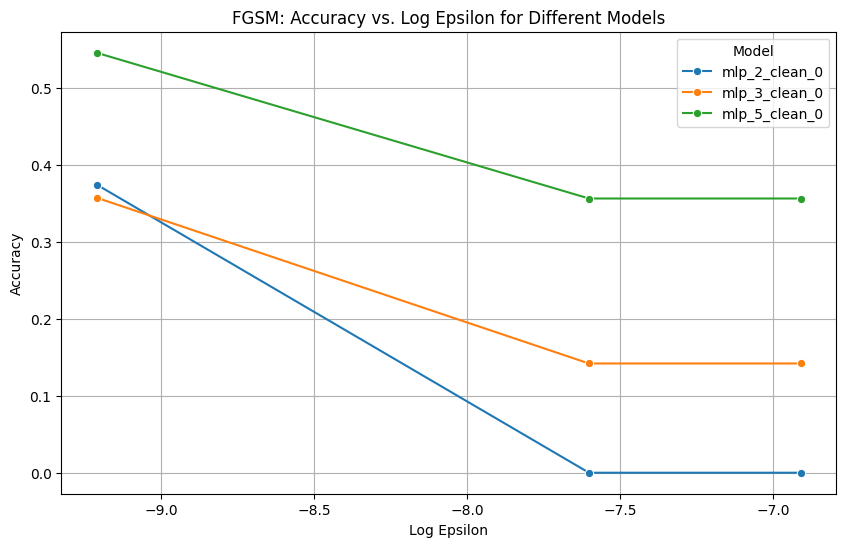

,model,epsilon,accuracy,log_epsilon
0,mlp_2_clean_0,0.0001,0.374288,-9.210340
1,mlp_2_clean_0,0.0005,0.000000,-7.600902
2,mlp_2_clean_0,0.0010,0.000000,-6.907755
3,mlp_3_clean_0,0.0001,0.357201,-9.210340
4,mlp_3_clean_0,0.0005,0.141850,-7.600902
5,mlp_3_clean_0,0.0010,0.141850,-6.907755
6,mlp_5_clean_0,0.0001,0.545430,-9.210340
7,mlp_5_clean_0,0.0005,0.356116,-7.600902
8,mlp_5_clean_0,0.0010,0.356116,-6.907755


In [ ]:
models = [model_mlp_2, model_mlp_3, model_mlp_5]

def experiment_fgsm(models, loader):
    epsilons = [0.0001, 0.0005, 0.001]

    accuracies = []

    for model in models:
        for eps in epsilons:
            accuracy, loss = run_epoch(model, loader, attack=fgsm, eps=eps, description=f"[Valid] Model: {model.name}, Epsilon: {eps:.5f}")
            accuracies.append({'model': model.name, 'epsilon': eps, 'accuracy': accuracy})

    accuracies_df = pd.DataFrame(accuracies)

    accuracies_df['log_epsilon'] = np.log(accuracies_df['epsilon'])

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=accuracies_df, x='log_epsilon', y='accuracy', hue='model', marker='o')

    plt.xlabel('Log Epsilon')
    plt.ylabel('Accuracy')
    plt.title('FGSM: Accuracy vs. Log Epsilon for Different Models')
    plt.legend(title='Model')
    plt.grid(True)
    plt.show()

    return accuracies_df

experiment_fgsm(models, valid_loader)

### ALBERT

In [ ]:
def fgsm_albert(model, data, eps=0.01, return_query_count=False, **kwargs):
    model.eval()

    input_ids = data['input_ids'].to(device)
    labels = data['labels'].to(device)

    embedding_layer = model.get_input_embeddings()
    embedding_layer.to(device)
    embeddings = embedding_layer(input_ids)

    delta = torch.zeros_like(embeddings, requires_grad=True)
    perturbed_embeddings = embeddings + delta

    outputs = model(inputs_embeds=perturbed_embeddings,
                    attention_mask=data['attention_mask'].to(device),
                    labels=labels)

    loss = outputs.loss
    model.zero_grad()
    loss.backward()

    perturbed_delta = eps * delta.grad.detach().sign()
    perturbed_embeddings = embeddings + perturbed_delta
    perturbed_embeddings = perturbed_embeddings.detach()

    adv_outputs = model(inputs_embeds=perturbed_embeddings, attention_mask=data['attention_mask'].to(device))
    adv_preds = torch.argmax(adv_outputs.logits, dim=1)

    correct_predictions = (adv_preds == labels).sum().item()

    if return_query_count:
        return perturbed_delta, perturbed_embeddings, correct_predictions, 1
    return perturbed_delta, perturbed_embeddings, correct_predictions

def run_albert_epoch(model, loader, attack, opt=None, description='', **kwargs):
    if opt is not None:
        description = "Training   " if description == '' else description
    else:
        description = "Validation " if description == '' else description

    total_correct_predictions = 0

    with tqdm(enumerate(loader), total=len(loader), desc=description) as bar:
        for i, data in bar:
            deltas, perturbed_embeddings, correct_predictions = attack(model, data, **kwargs)
            total_correct_predictions += correct_predictions

    accuracy = total_correct_predictions / len(loader.dataset)

    return accuracy


In [ ]:
epsilons = [0.01, 0.1, 1.0]
accuracies = []
for eps in epsilons:
    accuracy = run_albert_epoch(albert, albert_val_loader, attack=fgsm_albert, opt=None, description='ALBERT', eps=eps)
    accuracies.append({'epsilon': eps, 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)
accuracies_df

ALBERT: 100%|██████████| 231/231 [07:57<00:00,  2.07s/it]


,epsilon,accuracy
0,0.01,0.153241
1,0.10,0.235964
2,1.00,0.261730


## Projected Gradient Descent

The average absolute value of the gradient for any given feature is around 10^-5 at the initial zero point, necessitating scaling by a relatively large α to make any progress. Once we "break out" of the initial region around δ=0, the gradients typically increase substantially in magnitude. At this point, our large α becomes excessive, causing the method to take too large a step toward the boundary, effectively acting like FGSM.

### PGD Infinity Norm

In [ ]:
def pgd_linf(model, X, y, eps=0.0005, alpha=0.00005, num_iter=50, return_query_count=False):
    model.eval()
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.BCELoss()(model(X + delta).squeeze(1), y)
        loss.backward()
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-eps, eps)
        delta.grad.zero_()

    if return_query_count:
        return delta.detach(), num_iter
    return delta.detach()

[Valid] Model: mlp_2_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:05<00:00,  2.78it/s]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0005, Alpha: 0.0001: 100%|██████████| 15/15 [00:05<00:00,  2.77it/s]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0010, Alpha: 0.0001: 100%|██████████| 15/15 [00:05<00:00,  2.89it/s]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:05<00:00,  2.85it/s]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0005, Alpha: 0.0001: 100%|██████████| 15/15 [00:05<00:00,  2.90it/s]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0010, Alpha: 0.0001: 100%|██████████| 15/15 [00:05<00:00,  2.88it/s]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:05<00:00,  2.88it/s]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0005, Alpha: 0.0001: 100%|██████████| 15/15 [00:05<00:00,  2.88it/s]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0010, Alpha: 0.0001: 100%|██████████| 15/15 [00:05<00:00,  2.86it/s]


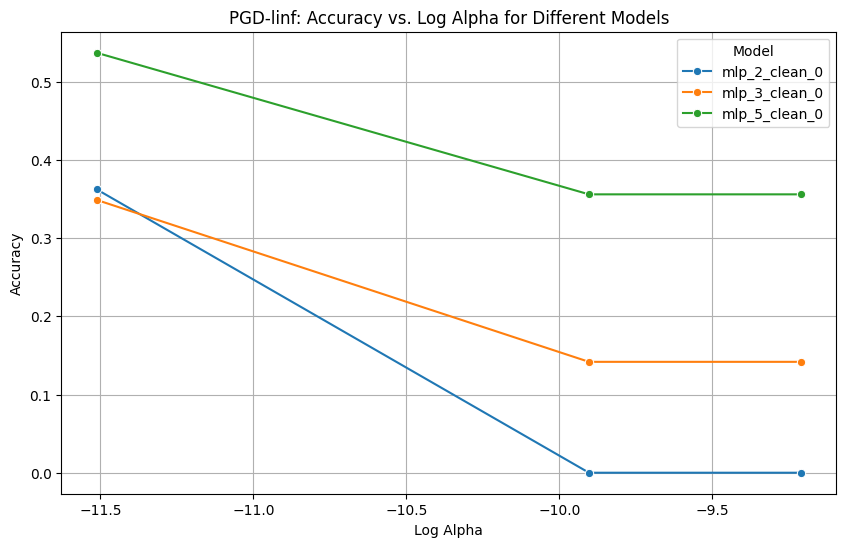

,model,alpha,accuracy,log_alpha
0,mlp_2_clean_0,0.00001,0.362625,-11.512925
1,mlp_2_clean_0,0.00005,0.000000,-9.903488
2,mlp_2_clean_0,0.00010,0.000000,-9.210340
3,mlp_3_clean_0,0.00001,0.349064,-11.512925
4,mlp_3_clean_0,0.00005,0.141850,-9.903488
5,mlp_3_clean_0,0.00010,0.141850,-9.210340
6,mlp_5_clean_0,0.00001,0.537293,-11.512925
7,mlp_5_clean_0,0.00005,0.356116,-9.903488
8,mlp_5_clean_0,0.00010,0.356116,-9.210340


In [ ]:
models = [model_mlp_2, model_mlp_3, model_mlp_5]
epsilons = [0.0001, 0.0005, 0.001]
alphas = [eps / 10.0 for eps in epsilons]
iters = len(alphas) * [10]

accuracies = []

for model in models:
    for i in range(len(alphas)):
        accuracy, loss = run_epoch(model, valid_loader, attack=pgd_linf, eps=epsilons[i],
                                   alpha=alphas[i], num_iter=iters[i],
                                   description=f"[Valid] Model: {model.name}, Epsilon: {epsilons[i]:.4f}, Alpha: {alphas[i]:.4f}")

        accuracies.append({'model': model.name, 'alpha': alphas[i], 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)

accuracies_df['log_alpha'] = np.log(accuracies_df['alpha'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=accuracies_df, x='log_alpha', y='accuracy', hue='model', marker='o')

plt.xlabel('Log Alpha')
plt.ylabel('Accuracy')
plt.title('PGD-linf: Accuracy vs. Log Alpha for Different Models')
plt.legend(title='Model')
plt.grid(True)
plt.show()

accuracies_df

In [ ]:
def pgd_linf_albert(model, data, eps=0.1, alpha=0.01, num_iter=5, return_query_count=False, **kwargs):
    model.eval()

    input_ids = data['input_ids'].to(device)
    labels = data['labels'].to(device)

    embedding_layer = model.get_input_embeddings()
    embedding_layer.to(device)
    embeddings = embedding_layer(input_ids).detach()

    delta = torch.zeros_like(embeddings, requires_grad=True)

    for t in range(num_iter):
        perturbed_embeddings = embeddings + delta

        outputs = model(inputs_embeds=perturbed_embeddings,
                        attention_mask=data['attention_mask'].to(device),
                        labels=labels)

        loss = outputs.loss
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            delta += alpha * delta.grad.detach().sign()
            delta.clamp_(-eps, eps)

    perturbed_embeddings = embeddings + delta
    perturbed_embeddings = perturbed_embeddings.detach()

    adv_outputs = model(inputs_embeds=perturbed_embeddings, attention_mask=data['attention_mask'].to(device))
    adv_preds = torch.argmax(adv_outputs.logits, dim=1)

    correct_predictions = (adv_preds == labels).sum().item()

    if return_query_count:
        return delta, perturbed_embeddings, correct_predictions, 1
    return delta, perturbed_embeddings, correct_predictions

In [ ]:
epsilons = [0.001, 0.01, 0.1]
alphas = [0.0001, 0.001, 0.01]
accuracies = []
for i, eps in enumerate(epsilons):
    accuracy = run_albert_epoch(albert, albert_val_loader, attack=pgd_linf_albert, opt=None, description='ALBERT', eps=eps, alpha=alphas[i])
    accuracies.append({'epsilon': eps, 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)
accuracies_df

ALBERT: 100%|██████████| 231/231 [31:00<00:00,  8.05s/it]


,epsilon,accuracy
0,0.001,0.965012
1,0.010,0.242474
2,0.100,0.035801


### PGD Infinity Norm with Random Restarts

The performance of PGD is still constrained by the potential presence of local optima within the objective. Although it's impossible to completely eliminate the occurrence of local optima, we can somewhat alleviate this issue through random restarts.

In [ ]:
def pgd_linf_rand(model, X, y, eps=0.0005, alpha=0.00005, num_iter=50, restarts=5, return_query_count=False):
    model.eval()
    max_loss = torch.zeros(X.shape[0]).to(y.device)
    max_delta = torch.zeros_like(X)

    for i in range(restarts):
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * eps - eps

        for t in range(num_iter):
            loss = nn.BCELoss()(model(X + delta).squeeze(1), y)
            loss.backward()
            delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-eps, eps)
            delta.grad.zero_()

        all_loss = nn.BCELoss(reduction='none')(model(X + delta).squeeze(1), y)
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)

    if return_query_count:
        return max_delta, num_iter * restarts + restarts

    return max_delta

[Valid] Model: mlp_2_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:22<00:00,  1.53s/it]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0005, Alpha: 0.0001: 100%|██████████| 15/15 [00:22<00:00,  1.53s/it]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0010, Alpha: 0.0001: 100%|██████████| 15/15 [00:22<00:00,  1.50s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:22<00:00,  1.51s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0005, Alpha: 0.0001: 100%|██████████| 15/15 [00:22<00:00,  1.51s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0010, Alpha: 0.0001: 100%|██████████| 15/15 [00:22<00:00,  1.49s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:22<00:00,  1.51s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0005, Alpha: 0.0001: 100%|██████████| 15/15 [00:22<00:00,  1.49s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0010, Alpha: 0.0001: 100%|██████████| 15/15 [00:22<00:00,  1.48s/it]


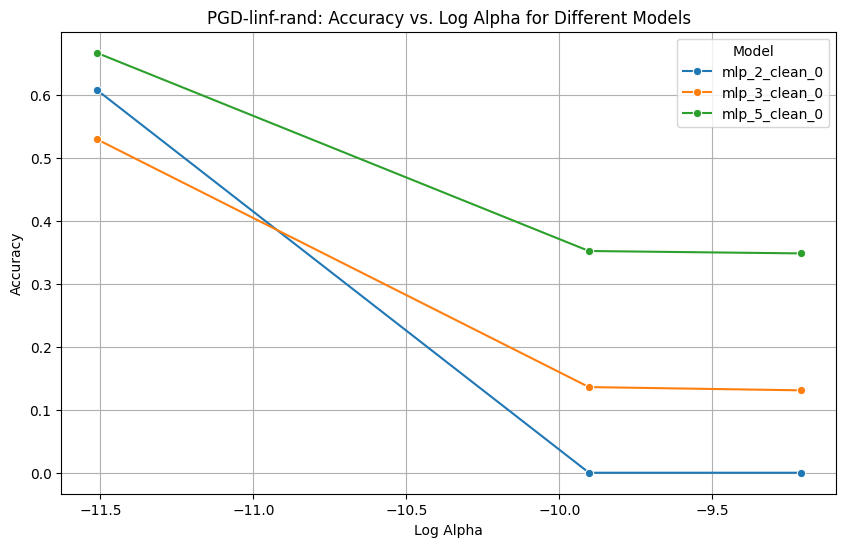

,model,alpha,accuracy,log_alpha
0,mlp_2_clean_0,0.00001,0.607811,-11.512925
1,mlp_2_clean_0,0.00005,0.000000,-9.903488
2,mlp_2_clean_0,0.00010,0.000000,-9.210340
3,mlp_3_clean_0,0.00001,0.529428,-11.512925
4,mlp_3_clean_0,0.00005,0.135883,-9.903488
5,mlp_3_clean_0,0.00010,0.130730,-9.210340
6,mlp_5_clean_0,0.00001,0.666395,-11.512925
7,mlp_5_clean_0,0.00005,0.351777,-9.903488
8,mlp_5_clean_0,0.00010,0.347979,-9.210340


In [ ]:
models = [model_mlp_2, model_mlp_3, model_mlp_5]
epsilons = [0.0001, 0.0005, 0.001]
alphas = [eps / 10.0 for eps in epsilons]
iters = len(alphas) * [10]

accuracies = []

for model in models:
    for i in range(len(alphas)):
        accuracy, loss = run_epoch(model, valid_loader, attack=pgd_linf_rand, eps=epsilons[i],
                                   alpha=alphas[i], num_iter=iters[i],
                                   description=f"[Valid] Model: {model.name}, Epsilon: {epsilons[i]:.4f}, Alpha: {alphas[i]:.4f}")

        accuracies.append({'model': model.name, 'alpha': alphas[i], 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)

accuracies_df['log_alpha'] = np.log(accuracies_df['alpha'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=accuracies_df, x='log_alpha', y='accuracy', hue='model', marker='o')

plt.xlabel('Log Alpha')
plt.ylabel('Accuracy')
plt.title('PGD-linf-rand: Accuracy vs. Log Alpha for Different Models')
plt.legend(title='Model')
plt.grid(True)
plt.show()

accuracies_df

### PGD L2 Norm

In [ ]:
def norms(Z):
    return Z.norm(dim=1)[:, None] + 1e-10


def pgd_l2(model, X, y, eps=0.05, alpha=0.05/20, num_iter=10, return_query_count=False):
    model.eval()
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.BCELoss()(model(X + delta).squeeze(1), y)
        loss.backward()
        delta.data += alpha * delta.grad.detach() / norms(delta.grad.detach())
        delta.data *= eps / norms(delta.detach()).clamp(min=eps)
        delta.grad.zero_()

    if return_query_count:
        return delta.detach(), num_iter

    return delta.detach()

[Valid] Model: mlp_2_clean_0, Epsilon: 0.0500, Alpha: 0.0025: 100%|██████████| 15/15 [00:24<00:00,  1.65s/it]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.1000, Alpha: 0.0050: 100%|██████████| 15/15 [00:23<00:00,  1.54s/it]
[Valid] Model: mlp_2_clean_0, Epsilon: 1.0000, Alpha: 0.0500: 100%|██████████| 15/15 [00:22<00:00,  1.48s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0500, Alpha: 0.0025: 100%|██████████| 15/15 [00:22<00:00,  1.52s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.1000, Alpha: 0.0050: 100%|██████████| 15/15 [00:22<00:00,  1.52s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 1.0000, Alpha: 0.0500: 100%|██████████| 15/15 [00:22<00:00,  1.52s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0500, Alpha: 0.0025: 100%|██████████| 15/15 [00:22<00:00,  1.50s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.1000, Alpha: 0.0050: 100%|██████████| 15/15 [00:22<00:00,  1.51s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 1.0000, Alpha: 0.0500: 100%|██████████| 15/15 [00:22<00:00,  1.51s/it]


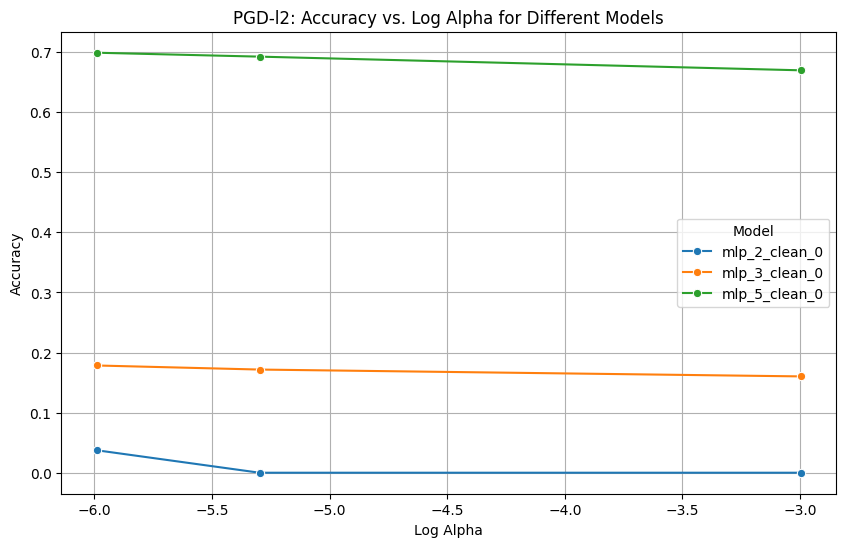

,model,alpha,accuracy,log_alpha
0,mlp_2_clean_0,0.0025,0.037429,-5.991465
1,mlp_2_clean_0,0.0050,0.000000,-5.298317
2,mlp_2_clean_0,0.0500,0.000000,-2.995732
3,mlp_3_clean_0,0.0025,0.178465,-5.991465
4,mlp_3_clean_0,0.0050,0.171684,-5.298317
5,mlp_3_clean_0,0.0500,0.160293,-2.995732
6,mlp_5_clean_0,0.0025,0.698942,-5.991465
7,mlp_5_clean_0,0.0050,0.692433,-5.298317
8,mlp_5_clean_0,0.0500,0.669650,-2.995732


In [ ]:
models = [model_mlp_2, model_mlp_3, model_mlp_5]
epsilons = [0.05, 0.1, 1.0]
alphas = [eps / 20.0 for eps in epsilons]
iters = len(alphas) * [50]

accuracies = []

for model in models:
    for i in range(len(alphas)):
        accuracy, loss = run_epoch(model, valid_loader, attack=pgd_l2, eps=epsilons[i],
                                   alpha=alphas[i], num_iter=iters[i],
                                   description=f"[Valid] Model: {model.name}, Epsilon: {epsilons[i]:.4f}, Alpha: {alphas[i]:.4f}")

        accuracies.append({'model': model.name, 'alpha': alphas[i], 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)

accuracies_df['log_alpha'] = np.log(accuracies_df['alpha'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=accuracies_df, x='log_alpha', y='accuracy', hue='model', marker='o')

plt.xlabel('Log Alpha')
plt.ylabel('Accuracy')
plt.title('PGD-l2: Accuracy vs. Log Alpha for Different Models')
plt.legend(title='Model')
plt.grid(True)
plt.show()

accuracies_df

In [ ]:
def norms(Z):
    return Z.norm(dim=1)[:, None] + 1e-10

def pgd_l2_albert(model, data, eps=1.0, alpha=0.1, num_iter=5, return_query_count=False, **kwargs):
    model.eval()

    input_ids = data['input_ids'].to(device)
    labels = data['labels'].to(device)

    embedding_layer = model.get_input_embeddings()
    embedding_layer.to(device)
    embeddings = embedding_layer(input_ids).detach()

    delta = torch.zeros_like(embeddings, requires_grad=True)

    for t in range(num_iter):
        perturbed_embeddings = embeddings + delta

        outputs = model(inputs_embeds=perturbed_embeddings,
                        attention_mask=data['attention_mask'].to(device),
                        labels=labels)

        loss = outputs.loss
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            delta += alpha * delta.grad.detach() / norms(delta.grad.detach())
            delta *= eps / norms(delta.detach()).clamp(min=eps)

    perturbed_embeddings = embeddings + delta
    perturbed_embeddings = perturbed_embeddings.detach()

    adv_outputs = model(inputs_embeds=perturbed_embeddings, attention_mask=data['attention_mask'].to(device))
    adv_preds = torch.argmax(adv_outputs.logits, dim=1)

    correct_predictions = (adv_preds == labels).sum().item()

    if return_query_count:
        return delta, perturbed_embeddings, correct_predictions, 1
    return delta, perturbed_embeddings, correct_predictions

In [ ]:
epsilons = [0.01, 0.1, 1.0]
alphas = [0.001, 0.01, 0.1]
accuracies = []
for i, eps in enumerate(epsilons):
    accuracy = run_albert_epoch(albert, albert_val_loader, attack=pgd_l2_albert, opt=None, description='ALBERT', eps=eps, alpha=alphas[i])
    accuracies.append({'epsilon': eps, 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)
accuracies_df

ALBERT: 100%|██████████| 231/231 [30:59<00:00,  8.05s/it]


,epsilon,accuracy
0,0.01,0.950095
1,0.10,0.229184
2,1.00,0.059940


### PGD L2 Norm with Random Restarts

In [ ]:
def pgd_l2_rand(model, X, y, eps=1.0, alpha=1.0/20, num_iter=50, restarts=5, return_query_count=False):
    model.eval()
    max_loss = torch.zeros(X.shape[0]).to(y.device)
    max_delta = torch.zeros_like(X)

    for i in range(restarts):
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * eps - eps

        for t in range(num_iter):
            loss = nn.BCELoss()(model(X + delta).squeeze(1), y)
            loss.backward()
            delta.data += alpha * delta.grad.detach() / norms(delta.grad.detach())
            delta.data *= eps / norms(delta.detach()).clamp(min=eps)
            delta.grad.zero_()

        all_loss = nn.BCELoss(reduction='none')(model(X + delta).squeeze(1), y)
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)

    if return_query_count:
        return max_delta, num_iter * restarts + restarts

    return max_delta

[Valid] Model: mlp_2_clean_0, Epsilon: 0.0500, Alpha: 0.0025: 100%|██████████| 15/15 [01:52<00:00,  7.50s/it]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.1000, Alpha: 0.0050: 100%|██████████| 15/15 [01:51<00:00,  7.46s/it]
[Valid] Model: mlp_2_clean_0, Epsilon: 1.0000, Alpha: 0.0500: 100%|██████████| 15/15 [01:47<00:00,  7.20s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0500, Alpha: 0.0025: 100%|██████████| 15/15 [01:50<00:00,  7.37s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.1000, Alpha: 0.0050: 100%|██████████| 15/15 [01:49<00:00,  7.28s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 1.0000, Alpha: 0.0500: 100%|██████████| 15/15 [01:48<00:00,  7.20s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0500, Alpha: 0.0025: 100%|██████████| 15/15 [01:50<00:00,  7.36s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.1000, Alpha: 0.0050: 100%|██████████| 15/15 [01:50<00:00,  7.33s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 1.0000, Alpha: 0.0500: 100%|██████████| 15/15 [01:49<00:00,  7.29s/it]


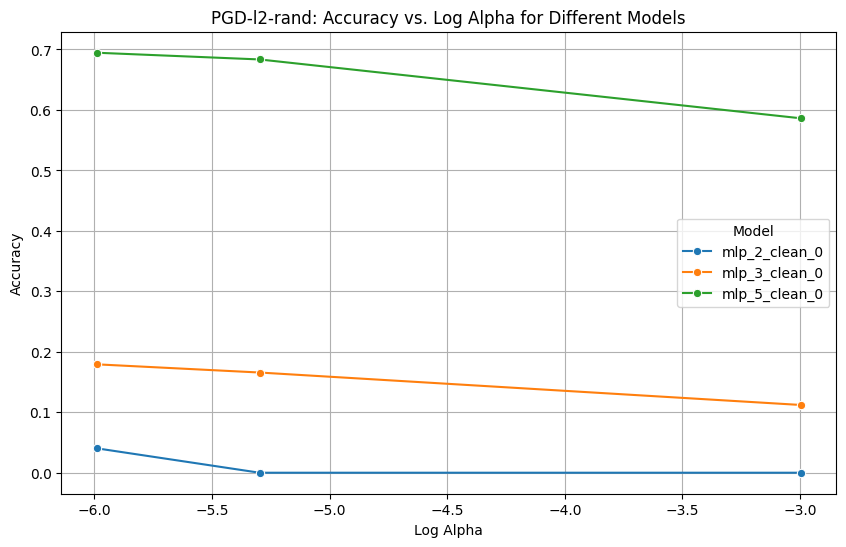

,model,alpha,accuracy,log_alpha
0,mlp_2_clean_0,0.0025,0.040412,-5.991465
1,mlp_2_clean_0,0.0050,0.000000,-5.298317
2,mlp_2_clean_0,0.0500,0.000000,-2.995732
3,mlp_3_clean_0,0.0025,0.179279,-5.991465
4,mlp_3_clean_0,0.0050,0.165717,-5.298317
5,mlp_3_clean_0,0.0500,0.112015,-2.995732
6,mlp_5_clean_0,0.0025,0.694603,-5.991465
7,mlp_5_clean_0,0.0050,0.683483,-5.298317
8,mlp_5_clean_0,0.0500,0.586113,-2.995732


In [ ]:
models = [model_mlp_2, model_mlp_3, model_mlp_5]
epsilons = [0.05, 0.1, 1.0]
alphas = [eps / 20.0 for eps in epsilons]
iters = len(alphas) * [50]

accuracies = []

for model in models:
    for i in range(len(alphas)):
        accuracy, loss = run_epoch(model, valid_loader, attack=pgd_l2_rand, eps=epsilons[i],
                                   alpha=alphas[i], num_iter=iters[i],
                                   description=f"[Valid] Model: {model.name}, Epsilon: {epsilons[i]:.4f}, Alpha: {alphas[i]:.4f}")

        accuracies.append({'model': model.name, 'alpha': alphas[i], 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)

accuracies_df['log_alpha'] = np.log(accuracies_df['alpha'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=accuracies_df, x='log_alpha', y='accuracy', hue='model', marker='o')

plt.xlabel('Log Alpha')
plt.ylabel('Accuracy')
plt.title('PGD-l2-rand: Accuracy vs. Log Alpha for Different Models')
plt.legend(title='Model')
plt.grid(True)
plt.show()

accuracies_df

## Targeted Attacks
In targeted attacks, we maximize the loss associated with the true label while also minimizing the loss for the alternative label.

In [ ]:
def pgd_linf_targ(model, X, y, eps=0.0001, alpha=0.00001, num_iter=50, y_targ=0, return_query_count=False):
    model.eval()

    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        yp = torch.concat([1 - yp, yp], axis=1)
        loss = (yp[:, y_targ].unsqueeze(1) - yp.gather(1, y.long()[:, None])).sum()
        loss.backward()
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-eps, eps)
        delta.grad.zero_()

    if return_query_count:
        return delta.detach(), num_iter

    return delta.detach()

[Valid] Model: mlp_2_clean_0, Epsilon: 0.0000, Alpha: 0.0000: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0005, Alpha: 0.0001: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0000, Alpha: 0.0000: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0005, Alpha: 0.0001: 100%|██████████| 15/15 [00:20<00:00,  1.38s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0000, Alpha: 0.0000: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0005, Alpha: 0.0001: 100%|██████████| 15/15 [00:20<00:00,  1.35s/it]


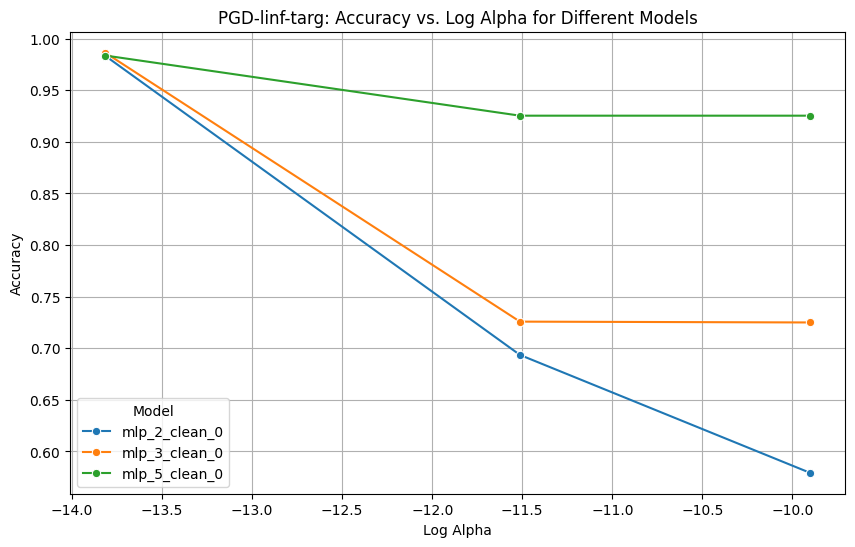

,model,alpha,accuracy,log_alpha
0,mlp_2_clean_0,0.000001,0.983455,-13.815511
1,mlp_2_clean_0,0.000010,0.693518,-11.512925
2,mlp_2_clean_0,0.000050,0.579333,-9.903488
3,mlp_3_clean_0,0.000001,0.986439,-13.815511
4,mlp_3_clean_0,0.000010,0.725793,-11.512925
5,mlp_3_clean_0,0.000050,0.724980,-9.903488
6,mlp_5_clean_0,0.000001,0.983727,-13.815511
7,mlp_5_clean_0,0.000010,0.925414,-11.512925
8,mlp_5_clean_0,0.000050,0.925414,-9.903488


In [ ]:
models = [model_mlp_2, model_mlp_3, model_mlp_5]
epsilons = [0.00001, 0.0001, 0.0005]
alphas = [eps / 10.0 for eps in epsilons]
iters = len(alphas) * [50]

accuracies = []

for model in models:
    for i in range(len(alphas)):
        accuracy, loss = run_epoch(model, valid_loader, attack=pgd_linf_targ, eps=epsilons[i],
                                   alpha=alphas[i], num_iter=iters[i],
                                   description=f"[Valid] Model: {model.name}, Epsilon: {epsilons[i]:.4f}, Alpha: {alphas[i]:.4f}")

        accuracies.append({'model': model.name, 'alpha': alphas[i], 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)

accuracies_df['log_alpha'] = np.log(accuracies_df['alpha'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=accuracies_df, x='log_alpha', y='accuracy', hue='model', marker='o')

plt.xlabel('Log Alpha')
plt.ylabel('Accuracy')
plt.title('PGD-linf-targ: Accuracy vs. Log Alpha for Different Models')
plt.legend(title='Model')
plt.grid(True)
plt.show()

accuracies_df

In [ ]:
def pgd_linf_targ_albert(model, data, eps=0.1, alpha=0.01, num_iter=5, y_targ=0, return_query_count=False, **kwargs):
    model.eval()

    input_ids = data['input_ids'].to(device)
    labels = data['labels'].to(device)

    embedding_layer = model.get_input_embeddings()
    embedding_layer.to(device)
    embeddings = embedding_layer(input_ids).detach()

    delta = torch.zeros_like(embeddings, requires_grad=True)

    for t in range(num_iter):
        perturbed_embeddings = embeddings + delta

        outputs = model(inputs_embeds=perturbed_embeddings,
                        attention_mask=data['attention_mask'].to(device),
                        labels=labels)

        logits = outputs.logits
        loss = (logits[:, y_targ] - logits.gather(1, labels[:,None])[:,0]).sum()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            delta += alpha * delta.grad.detach().sign()
            delta.clamp_(-eps, eps)

    perturbed_embeddings = embeddings + delta
    perturbed_embeddings = perturbed_embeddings.detach()

    adv_outputs = model(inputs_embeds=perturbed_embeddings, attention_mask=data['attention_mask'].to(device))
    adv_preds = torch.argmax(adv_outputs.logits, dim=1)

    correct_predictions = (adv_preds == labels).sum().item()

    if return_query_count:
        return delta, perturbed_embeddings, correct_predictions, 1
    return delta, perturbed_embeddings, correct_predictions

In [ ]:
epsilons = [0.01, 0.1, 1.0]
alphas = [0.001, 0.01, 0.1]
accuracies = []
for i, eps in enumerate(epsilons):
    accuracy = run_albert_epoch(albert, albert_val_loader, attack=pgd_linf_targ_albert, opt=None, description='ALBERT', eps=eps, alpha=alphas[i])
    accuracies.append({'epsilon': eps, 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)
accuracies_df

ALBERT: 100%|██████████| 231/231 [30:20<00:00,  7.88s/it]


,epsilon,accuracy
0,0.01,0.611066
1,0.10,0.583130
2,1.00,0.668836


In [ ]:
def pgd_linf_targ2(model, X, y, eps=0.0005, alpha=0.0005/20, num_iter=40, y_targ=0, return_query_count=False):
    model.eval()
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        yp = torch.concat([1 - yp, yp], axis=1)
        loss = 2 * yp[:, y_targ].sum() - yp.sum()
        loss.backward()
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-eps, eps)
        delta.grad.zero_()

    if return_query_count:
        return delta.detach(), num_iter
    return delta.detach()

[Valid] Model: mlp_2_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0005, Alpha: 0.0000: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0008, Alpha: 0.0000: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]
[Valid] Model: mlp_2_clean_0, Epsilon: 0.0075, Alpha: 0.0004: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0005, Alpha: 0.0000: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0008, Alpha: 0.0000: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]
[Valid] Model: mlp_3_clean_0, Epsilon: 0.0075, Alpha: 0.0004: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]
[Valid] Model: mlp_5_clean_0, Epsilon: 0.0001, Alpha: 0.0000: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]
[Valid] Mo

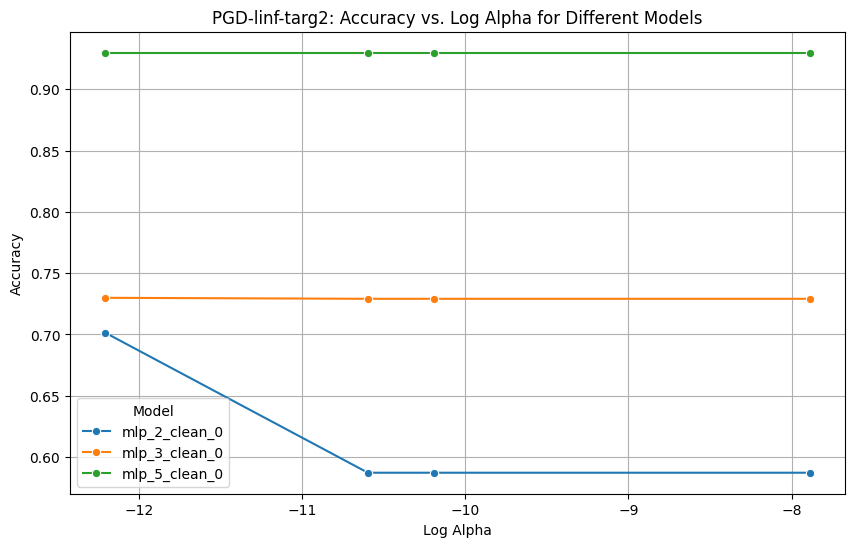

,model,alpha,accuracy,log_alpha
0,mlp_2_clean_0,0.000005,0.701383,-12.206073
1,mlp_2_clean_0,0.000025,0.587198,-10.596635
2,mlp_2_clean_0,0.000038,0.587198,-10.191170
3,mlp_2_clean_0,0.000375,0.587198,-7.888585
4,mlp_3_clean_0,0.000005,0.729862,-12.206073
5,mlp_3_clean_0,0.000025,0.729048,-10.596635
6,mlp_3_clean_0,0.000038,0.729048,-10.191170
7,mlp_3_clean_0,0.000375,0.729048,-7.888585
8,mlp_5_clean_0,0.000005,0.929753,-12.206073
9,mlp_5_clean_0,0.000025,0.929753,-10.596635


In [ ]:
models = [model_mlp_2, model_mlp_3, model_mlp_5]
epsilons = [0.0001, 0.0005, 0.00075, 0.0075]
alphas = [eps / 20.0 for eps in epsilons]
iters = len(alphas) * [50]

accuracies = []

for model in models:
    for i in range(len(alphas)):
        accuracy, loss = run_epoch(model, valid_loader, attack=pgd_linf_targ2, eps=epsilons[i],
                                   alpha=alphas[i], num_iter=iters[i],
                                   description=f"[Valid] Model: {model.name}, Epsilon: {epsilons[i]:.4f}, Alpha: {alphas[i]:.4f}")

        accuracies.append({'model': model.name, 'alpha': alphas[i], 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)

accuracies_df['log_alpha'] = np.log(accuracies_df['alpha'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=accuracies_df, x='log_alpha', y='accuracy', hue='model', marker='o')

plt.xlabel('Log Alpha')
plt.ylabel('Accuracy')
plt.title('PGD-linf-targ2: Accuracy vs. Log Alpha for Different Models')
plt.legend(title='Model')
plt.grid(True)
plt.show()

accuracies_df

In [ ]:
def pgd_linf_targ2_albert(model, data, eps=1.0, alpha=0.1, num_iter=5, y_targ=0, return_query_count=False, **kwargs):
    model.eval()
    input_ids = data['input_ids'].to(device)
    labels = data['labels'].to(device)

    embedding_layer = model.get_input_embeddings()
    embedding_layer.to(device)
    embeddings = embedding_layer(input_ids).detach()

    delta = torch.zeros_like(embeddings, requires_grad=True)

    for t in range(num_iter):
        perturbed_embeddings = embeddings + delta

        outputs = model(inputs_embeds=perturbed_embeddings,
                        attention_mask=data['attention_mask'].to(device),
                        labels=labels)

        logits = outputs.logits
        loss = 2 * logits[:, y_targ].sum() - logits.sum()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            delta += alpha * delta.grad.detach().sign()
            delta.clamp_(-eps, eps)

    perturbed_embeddings = embeddings + delta
    perturbed_embeddings = perturbed_embeddings.detach()

    adv_outputs = model(inputs_embeds=perturbed_embeddings, attention_mask=data['attention_mask'].to(device))
    adv_preds = torch.argmax(adv_outputs.logits, dim=1)

    correct_predictions = (adv_preds == labels).sum().item()

    if return_query_count:
        return delta, perturbed_embeddings, correct_predictions, 1
    return delta, perturbed_embeddings, correct_predictions

In [ ]:
epsilons = [0.01, 0.1, 1.0]
alphas = [0.001, 0.01, 0.1]
accuracies = []
for i, eps in enumerate(epsilons):
    accuracy = run_albert_epoch(albert, albert_val_loader, attack=pgd_linf_targ2_albert, opt=None, description='ALBERT', eps=eps, alpha=alphas[i])
    accuracies.append({'epsilon': eps, 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)
accuracies_df

ALBERT: 100%|██████████| 231/231 [31:00<00:00,  8.06s/it]


,epsilon,accuracy
0,0.01,0.621915
1,0.10,0.579333
2,1.00,0.539463


## Ensemble

In [ ]:
def ensemble_attack(model, inputs, labels, child_attacks, return_query_count=False):
    avg_deltas = None
    total_query_count = 0
    for attack in attacks:
        if return_query_count:
            deltas, query_count = attack(model, inputs, labels, return_query_count=True)
            total_query_count += query_count
        else:
            deltas = attack(model, inputs, labels, return_query_count=False)

        if avg_deltas is None:
            avg_deltas = deltas
        else:
            avg_deltas += deltas
    avg_deltas /= len(attacks)

    if return_query_count:
        return avg_deltas, total_query_count
    return avg_deltas

[Valid] Model: mlp_5: 100%|██████████| 15/15 [04:38<00:00, 18.53s/it]


,model,accuracy
0,mlp_2,0.000542
1,mlp_3,0.086249
2,mlp_5,0.431516


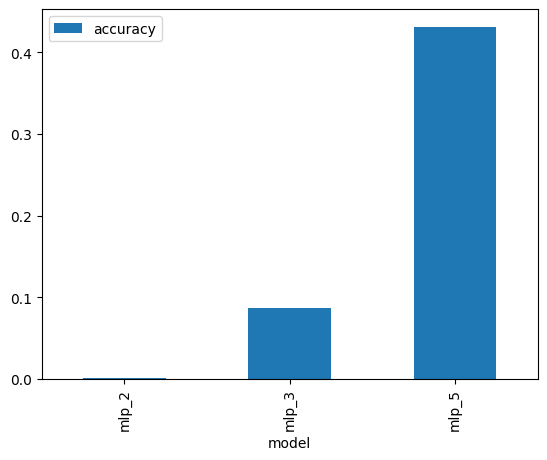

In [ ]:
attacks = [
    pgd_linf_targ2,
    pgd_linf_targ,
    pgd_l2,
    pgd_l2_rand,
    pgd_linf,
    pgd_linf_rand,
    fgsm
]
models = [model_mlp_2, model_mlp_3, model_mlp_5]

accuracies = []

for model in models:
    accuracy, loss = run_epoch(model, valid_loader, attack=ensemble_attack, child_attacks=attacks,
                               description=f"[Valid] Model: {model.name}")

    accuracies.append({'model': model.name, 'accuracy': accuracy})

accuracies_df = pd.DataFrame(accuracies)
accuracies_df.plot(x='model', y='accuracy', kind='bar')

accuracies_df

## Crafting Adversarial Emails in Word Space

In [ ]:
attacks = [
    # pgd_linf_targ2,
    # pgd_linf_targ,
    pgd_l2,
    # pgd_l2_rand,
    # pgd_linf,
    # pgd_linf_rand,
    # fgsm
]

attack_name = 'pgd_l2'
model = model_mlp_5
model.eval()

MLP(
  (blocks): ModuleList(
    (0): MLPBlock(
      (linear): Linear(in_features=24823, out_features=200, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): MLPBlock(
      (linear): Linear(in_features=200, out_features=100, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (2): MLPBlock(
      (linear): Linear(in_features=100, out_features=50, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (3): MLPBlock(
      (linear): Linear(in_features=50, out_features=25, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
  (output): Linear(in_features=25, out_features=1, bias=True)
)

### Crafting Adversarial Vocabulary

In [ ]:
y_spam_train = y_train[y_train == 1]
X_spam_train = X_train[y_train == 1]

train_spam_tfidf_df = pd.DataFrame(vectorizer.transform(X_spam_train).toarray(), columns=vectorizer.get_feature_names_out())
train_spam_loader = DataLoader(TFIDFDataset(train_spam_tfidf_df, y_spam_train), batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
train_delta_list = []

def wrap_attack(model, inputs, labels):
    avg_deltas = ensemble_attack(model, inputs, labels, attacks)

    train_delta_list.append(avg_deltas.cpu().detach().numpy())

    return avg_deltas

accuracy, loss = run_epoch(model, train_spam_loader, attack=wrap_attack,
                           description=f"Model: {model.name}")

train_deltas_df = pd.DataFrame(np.vstack(train_delta_list))

assert train_deltas_df.shape[0] == X_spam_train.shape[0]
assert train_deltas_df.shape[1] == train_tfidf_df.shape[1]

Model: mlp_5: 100%|██████████| 49/49 [00:11<00:00,  4.34it/s]


The key high-level element to note here is that while ℓ∞ attacks result in small noise distributed uniformly across the features (precisely because this type of perturbation is allowable under the ℓ∞ ball), ℓ2 attacks lead to perturbations that are more localized within the image. This occurs because we can "trade off" a larger perturbation at one point in the space for a smaller perturbation at another.

ℓ1 attacks, by the nature of the ℓ1 norm, encourage sparsity in the δ perturbation, i.e., they will have only a few features that are adjusted.

TODO:
1. Emperically compare l-inf and l2

In [ ]:
train_deltas_df.columns = train_tfidf_df.columns

In [ ]:
means = train_deltas_df.mean(axis=0)
top = int(train_deltas_df.shape[1] * 0.1)
top_means = means.sort_values(ascending=False).head(top)
to_insert_vocabulary = top_means.index.tolist()

In [ ]:
to_insert_vocabulary[0:5]

['ron', 'vince', 'louise', 'wrote', 'en']

### Computing Token Importance

In [ ]:
def find_indices(A, B):
    index_map = {val: i for i, val in enumerate(B)}
    indices = [index_map.get(a, None) for a in A]
    return [index for index in indices if index is not None]

def compute_token_importance(model, vectorizer, spam_sample):
    tfidf_sample = vectorizer.transform([spam_sample])
    df_sample = pd.DataFrame(tfidf_sample.toarray(), columns=vectorizer.get_feature_names_out())
    tensor_sample = torch.tensor(df_sample.to_numpy()).float().to(device)
    label_sample = torch.tensor([1]).float().to(device)

    indices = find_indices(spam_sample.split(), vectorizer.get_feature_names_out())

    to_replace = []
    avg_deltas = None
    total_query_count = 0
    for attack in attacks:
        delta, query_count = attack(model, tensor_sample, label_sample, return_query_count=True)
        total_query_count += query_count
        if avg_deltas is None:
            avg_deltas = delta.cpu().detach().numpy()
        else:
            avg_deltas += delta.cpu().detach().numpy()
    avg_deltas /= len(attacks)

    to_replace.extend([(vectorizer.get_feature_names_out()[idx], avg_deltas[0, idx]) for idx in indices if avg_deltas[0, idx] < 0])
    to_replace = sorted(to_replace, key=lambda x: x[1])

    return to_replace, total_query_count

### GPT Replacement Attack (Attempt 1)

In [ ]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.3/268.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.2 MB/s eta 0:00:00


In [ ]:
from openai import OpenAI

client = OpenAI(
    api_key='',
)

def get_completion(prompt, model="gpt-4-0125-preview", temperature=0):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )
    return response.choices[0].message.content

In [ ]:
def replace_placeholders(text, replacements):
    for replacement in replacements:
        text = text.replace("<< REPLACE ME >>", replacement.strip(), 1)
    return text

def fix_grammar_errors(email):
    prompt = f"""Fix the grammar errors in the following text:
    {email}
    """

    response = get_completion(prompt)
    return response.strip()

def top_k_candidates(adversarial_sample, to_replace, k=3, model='gpt-4-0125-preview', debug=False):
    replacement_count = adversarial_sample.count("<< REPLACE ME >>")
    candidate_replacements = set([to_replace, to_replace.capitalize()])

    candidates = []
    for i in range(k):
        prompt = f"""
            Step 1: Exactly replace {f"all {replacement_count} instances" if replacement_count > 1 else f"1 instance"} of "<< REPLACE ME >>" in the text enclosed by "!!!" with suitable words or phrases for logical reading flow and grammar correctness.
                Pick words/phrases from the vocabulary enclosed by "???" for replacements. Do NOT use words/phrases {', '.join([f'"{c}"' for c in candidate_replacements])} or stop words to replace "<< REPLACE ME >>".
            Step 2: Return only the replacements{', separate each with "|"' if replacement_count > 1 else ''}. Ensure the count of replacements to exactly be {replacement_count}.

        Masked text:
        !!!{adversarial_sample}!!!

        Vocabulary:
        ???{' '.join(to_insert_vocabulary)}???
        """
        # print(f"Prompt [{i}]:", prompt)
        response = get_completion(prompt, model=model)
        # print('GPT response:', response)

        replacements = response.strip().split('|')
        candidate_replacements.update(replacements)
        # print(replacements)

        replaced_text = replace_placeholders(adversarial_sample, replacements)
        candidates.append((replaced_text, replacements))

    # print(candidates)

    return candidates

In [ ]:
def predict(email, model, vectorizer):
    tfidf = vectorizer.transform([' '.join(tokenizer.tokenize(email))])
    df = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names_out())
    return model(torch.tensor(df.to_numpy()).float().to(device))

In [ ]:
def replace_attack(spam_sample, k=1):
    total_query_count = 0
    total_mlm_query_count = 0

    final_replacements = set()
    adversarial_sample = tokenizer.tokenize(spam_sample)

    to_replace, query_count = compute_token_importance(model, vectorizer, ' '.join(adversarial_sample))
    total_query_count += query_count
    for token, importance in to_replace:
        mask_indices = [i for i, word in enumerate(adversarial_sample) if word == token]
        # Mask all occurrences of the current to-replace token
        for mask_index in mask_indices:
            j = mask_index
            adversarial_sample[j] = '<< REPLACE ME >>'
            # Mask all word pieces of the current occurrence: ['sleep', '##ing'] => [MASK]
            for i in range(j + 1, len(adversarial_sample)):
                if adversarial_sample[i].startswith('##'):
                    adversarial_sample[i] = ''
                else:
                    break

            if adversarial_sample[j].startswith('##'):
                for i in range(j - 1, -1, -1):
                    adversarial_sample[i] = ''
                    if adversarial_sample[i].startswith('##') == False:
                        break


        adversarial_sample = [token for token in adversarial_sample if token != '']
        candidates = top_k_candidates(' '.join(adversarial_sample), token, k=k)
        total_mlm_query_count += k
        assert len(candidates) == k

        accuracies = [(candidate[0], predict(candidate[0].replace(' ##', ''), model, vectorizer).item(), candidate[1]) for candidate in candidates]
        total_query_count += 1
        sorted_accuracies = sorted(accuracies, key=lambda x: x[1])
        successful_candidates = [accuracy for accuracy in sorted_accuracies if accuracy[1] < 0.5]
        final_replacements.update(sorted_accuracies[0][2])
        if len(successful_candidates) > 0:
            print('Successful!', predict(successful_candidates[0][0].replace(' ##', ''), model, vectorizer).item())
            return successful_candidates[0][0], final_replacements
        else:
            adversarial_sample = sorted_accuracies[0][0].split(' ')

    print('Failed!    ', predict(' '.join(adversarial_sample).replace(' ##', ''), model, vectorizer).item())
    return ' '.join(adversarial_sample), final_replacements, total_query_count, total_mlm_query_count

In [ ]:
val_spam_df = X_val[y_val == 1].copy()
val_spam_df.reset_index(drop=True, inplace=True)
val_spam_df.shape

(1683,)

In [ ]:
raw_df = pd.read_csv(os.path.join(data_path, 'preprocessed/raw_all.csv'))

def get_original_spam(spam):
    return raw_df[raw_df['text'] == spam]['original_text'].iloc[0]

In [ ]:
spam_samples = val_spam_df.sample(25)
spam_samples.to_csv(os.path.join(output_path, 'spam_samples.csv'), index=False)
for spam in spam_samples:
    print(spam)
    print()

buy prescription medication from the comfort of your home ! your reliable source for prescription drugs without prescription a fault confessed is half red ##ressed . a certain amount of danger is essential to the quality of life . we can lick gravity , but sometimes the paperwork is overwhelming .

30 seconds application hello , we sent you an email a while ago , because you now qualify for a much lower rate based on the biggest rate drop in years . you can now get $ 300 , 000 for as little as $ 650 a month ! bad credit ? doesn ' t matter , low rates are fixed no matter what ! follow this link to process your application and a 24 hour approval : best regards , hope with ##ers ##poo ##n to be re ##mo ##v ( ed : http : / / www . dropped ##r 8 z . com / x / st . html

special promotion - get a $ 250 gift card a fly and a flea in a flu ##e a fly and a flea in a flu ##e were imprisoned , so what could they do ? said the fly , " let us flee ! " " let us fly ! " said the flea , and they flew 

In [ ]:
spam_samples = pd.read_csv(os.path.join(output_path, 'spam_samples.csv'))['text'].tolist()

results = []
for spam_sample in spam_samples:
    adversarial_sample, final_replacements, query_count, mlm_query_count = replace_attack(fix_grammar_errors(spam_sample))
    results.append((get_original_spam(spam_sample), spam_sample, adversarial_sample, final_replacements, query_count, mlm_query_count))

Successful! 0.06484543532133102
Failed! 0.9968191385269165
Successful! 0.0011184531031176448
Successful! 0.07755810767412186
Failed! 0.9332521557807922
Successful! 0.21789111196994781
Successful! 0.3575693964958191
Successful! 0.22540229558944702
Failed! 0.9990678429603577
Successful! 0.09016512334346771
Successful! 0.48193666338920593
Successful! 0.3422832489013672
Failed! 0.1713535338640213
Successful! 0.4441002607345581
Successful! 0.0016708432231098413
Failed! 0.9443255066871643
Failed! 1.0
Successful! 0.016207927837967873
Successful! 0.00496546970680356
Successful! 0.07070916891098022
Successful! 0.41543400287628174
Successful! 0.45065152645111084
Successful! 0.0326937772333622
Successful! 0.007547373417764902
Failed! 0.6896035671234131


In [ ]:
preds = []
for result in results:
    original_sample = result[0]
    spam_sample = result[1]
    adversarial_sample = result[2]

    # print('***' * 10)
    # print(f"Original sample: {original_sample}")

    # print(f"Spam sample: {spam_sample}")
    # print(predict(spam_sample, model, vectorizer).item())

    # print(f"Adversarial sample: {adversarial_sample}")
    # print(predict(adversarial_sample, model, vectorizer).item())

    result = result + (predict(spam_sample, model, vectorizer).item(),)
    result = result + (predict(adversarial_sample.replace(' ##', ''), model, vectorizer).item(),)
    preds.append(result)

In [ ]:
preds_df = pd.DataFrame(preds, columns=['original_sample', 'spam_sample', 'adversarial_sample', 'final_replacements', 'spam_sample_pred', 'adversarial_sample_pred', 'target_model_query_count', 'mlm_query_count'])
preds_df.to_csv(os.path.join(output_path, f'{attack_name}_gpt.csv'), index=False)

In [ ]:
preds_df

,original_sample,spam_sample,adversarial_sample,final_replacements,spam_sample_pred,adversarial_sample_pred
0,buy prescription medication from the comfort o...,buy prescription medication from the comfort o...,buy online medicinal from the comfort of your ...,"{drugs, your, reliable, medicinal, discussing,...",0.999994,0.064845
1,"30 seconds application hello ,\nwe sent you an...","30 seconds application hello , we sent you an ...","30 - second message : hello , our sent your lo...","{request, matter, notification, borrow, might,...",0.999999,0.996819
2,special promotion - get a $ 250 gift card a fl...,special promotion - get a $ 250 gift card a fl...,special promotion - get a $ 250 gift card a da...,"{flea, flee, dare}",0.999293,0.001118
3,"liffe is great hello ,\nvlsit our medsbymail s...","li ##ffe is great hello , v ##ls ##it our med ...","life is great ! hello , discuss our med ##s - ...","{to, magnesium, our, programme, discuss, be, u...",1.000000,0.077558
4,= ? utf - 8 ? q ? real replica watches ? = = ?...,= ? ut ##f - 8 ? q ? real replica watches ? = ...,certainly ! here ' s a corrected version of th...,"{genuine, watches, Rolex, ron, vince}",0.999990,0.933252
5,you won our xmas bonanza lottery eagel lotto b...,you won our x ##mas bon ##anza lottery ea ##ge...,"ron vince vince x ##mas bon ##anza lottery , e...","{louise, mention, ticket, part, award, quickly...",0.999988,0.217891
6,would you believe it ? i think you ' re meant ...,would you believe it ? i think you ' re meant ...,would would believe it ? i think anyone ' re m...,"{logical, clear, walk, they, succeed, would, y...",0.994715,0.357569
7,"\ / 1 coddin , codeilne ; vlaagrra . xanaa , c...","/ 1 cod ##din , code ##il ##ne ; v ##la ##ag #...",the provided text appears to be a linguistic o...,"{wrote, sought, purpose, global, mistakes, he...",1.000000,0.225402
8,"online software , download ms 2003 , adobe , w...","online software , download ms 2003 , adobe , w...","online utilities , utilities ms office , adobe...","{using, interface, to, disasters, encryption, ...",1.000000,0.999068
9,better health and prosperity since 1924 our of...,better health and prosperity since 1924 our of...,better linguistics linguistics linguistics sin...,"{linguistics, supplied, remain, erectile, slee...",0.999995,0.090165


### GPT Replacement Attack (Attempt 2)


In [ ]:
attacks = [
    # pgd_linf_targ2_albert,
    # pgd_linf_targ_albert,
    # pgd_l2_albert,
    pgd_linf_albert,
]

attack_name = 'albert_pgd_linf_targ2_cleaned_2'
model = albert

model.eval()

MLP(
  (blocks): ModuleList(
    (0): MLPBlock(
      (linear): Linear(in_features=173676, out_features=200, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): MLPBlock(
      (linear): Linear(in_features=200, out_features=100, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (2): MLPBlock(
      (linear): Linear(in_features=100, out_features=50, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (3): MLPBlock(
      (linear): Linear(in_features=50, out_features=25, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
  (output): Linear(in_features=25, out_features=1, bias=True)
)

In [ ]:
val_spam_df = X_val[y_val == 1].copy()
val_spam_df.reset_index(drop=True, inplace=True)
val_spam_df.shape

(1522,)

In [ ]:
val_spam_df = pd.DataFrame({'text': val_spam_df, 'labels': [1] * val_spam_df.shape[0]})
val_spam_dataset = Dataset.from_pandas(val_spam_df)
val_spam_dataset = val_spam_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

In [ ]:
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

def transform_to_albert_input(sample):
    inputs = tokenizer(sample, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    inputs = {key: value.to(device) for key, value in inputs.items()}
    return inputs

In [ ]:
def predict(sample, model, label=1):
    inputs = tokenizer(sample, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits.squeeze()
    probabilities = torch.softmax(logits, dim=-1)

    return probabilities[label].item()

In [ ]:
import copy
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

filter_words = ['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'ain', 'all', 'almost',
                'alone', 'along', 'already', 'also', 'although', 'am', 'among', 'amongst', 'an', 'and', 'another',
                'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'aren', "aren't", 'around', 'as',
                'at', 'back', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides',
                'between', 'beyond', 'both', 'but', 'by', 'can', 'cannot', 'could', 'couldn', "couldn't", 'd', 'didn',
                "didn't", 'doesn', "doesn't", 'don', "don't", 'down', 'due', 'during', 'either', 'else', 'elsewhere',
                'empty', 'enough', 'even', 'ever', 'everyone', 'everything', 'everywhere', 'except', 'first', 'for',
                'former', 'formerly', 'from', 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'he', 'hence',
                'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers', 'herself', 'him', 'himself', 'his',
                'how', 'however', 'hundred', 'i', 'if', 'in', 'indeed', 'into', 'is', 'isn', "isn't", 'it', "it's",
                'its', 'itself', 'just', 'latter', 'latterly', 'least', 'll', 'may', 'me', 'meanwhile', 'mightn',
                "mightn't", 'mine', 'more', 'moreover', 'most', 'mostly', 'must', 'mustn', "mustn't", 'my', 'myself',
                'namely', 'needn', "needn't", 'neither', 'never', 'nevertheless', 'next', 'no', 'nobody', 'none',
                'noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'o', 'of', 'off', 'on', 'once', 'one', 'only',
                'onto', 'or', 'other', 'others', 'otherwise', 'our', 'ours', 'ourselves', 'out', 'over', 'per',
                'please', 's', 'same', 'shan', "shan't", 'she', "she's", "should've", 'shouldn', "shouldn't", 'somehow',
                'something', 'sometime', 'somewhere', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs',
                'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein',
                'thereupon', 'these', 'they', 'this', 'those', 'through', 'throughout', 'thru', 'thus', 'to', 'too',
                'toward', 'towards', 'under', 'unless', 'until', 'up', 'upon', 'used', 've', 'was', 'wasn', "wasn't",
                'we', 'were', 'weren', "weren't", 'what', 'whatever', 'when', 'whence', 'whenever', 'where',
                'whereafter', 'whereas', 'whereby', 'wherein', 'whereupon', 'wherever', 'whether', 'which', 'while',
                'whither', 'who', 'whoever', 'whole', 'whom', 'whose', 'why', 'with', 'within', 'without', 'won',
                "won't", 'would', 'wouldn', "wouldn't", 'y', 'yet', 'you', "you'd", "you'll", "you're", "you've",
                'your', 'yours', 'yourself', 'yourselves']
filter_words = set(filter_words)

def find_indices(A, B):
    index_map = {val: i for i, val in enumerate(B)}
    indices = [index_map.get(a, None) for a in A]
    return [(i, index) for i, index in enumerate(indices) if index is not None]

def compute_token_importance(model, spam_sample):
    to_replace = []
    avg_deltas = None
    total_query_count = 0

    attention_mask = spam_sample['attention_mask'].squeeze()
    token_length = attention_mask.sum()

    for attack in attacks:
        delta, perturbed_embeddings, correct_predictions, query_count = attack(model, spam_sample, return_query_count=True)
        total_query_count += query_count
        if avg_deltas is None:
            avg_deltas = delta.cpu().detach()
        else:
            avg_deltas += delta.cpu().detach()
    avg_deltas /= len(attacks)

    important_values = None
    mean_abs_values = torch.mean(torch.abs(avg_deltas.squeeze()), dim=-1)
    important_values = [(value, pos) for value, mask, pos in zip(mean_abs_values, attention_mask, range(token_length)) if mask]
    important_values = sorted(important_values, key=lambda x: -x[0])

    decoded_text = tokenizer.decode(spam_sample['input_ids'].squeeze(), skip_special_tokens=True, clean_up_tokenization_spaces=True)

    tokens = tokenizer.convert_ids_to_tokens(spam_sample['input_ids'].squeeze())
    tokens = [token for token, mask in zip(tokens, attention_mask) if mask]

    assert max([value for value, pos in important_values]) > min([value for value, pos in important_values])
    assert attention_mask.sum() == len(tokens)
    assert attention_mask.sum() == len(important_values)
    return important_values, tokens, decoded_text, attention_mask, total_query_count

email_id = 1000
spam_sample = {}

spam_sample['labels'] = torch.tensor(1).unsqueeze(0).to(device)
spam_sample['input_ids'] = torch.tensor(val_spam_dataset[email_id]['input_ids']).unsqueeze(0).to(device)
spam_sample['attention_mask'] = torch.tensor(val_spam_dataset[email_id]['attention_mask']).unsqueeze(0).to(device)

important_values, tokens, decoded_text, attention_mask, total_query_count = compute_token_importance(model, spam_sample)
print(important_values[2])
print(tokens[important_values[2][1]])
text = val_spam_dataset[email_id]['text']
print(text)

(tensor(0.4906), 494)
▁money
assistance from : ahmed seiko email : ahmed  se @ arabtop . net dubai - uae dear friend , i am ahmed from zaire , presently known as democratic republic of congo . i am the son of late maramotto sese seiko , the former central bank governor , during the regime of his immediate senior brother , late president mobutu sese seiko of zaire , republic of congo . i got your contact from chambers of commerce and industry here in dubai . as a result of my discrete search for a reliable foreign partner , i am delighted to confront you based on a profile conviction about your experience in investment programmed . i now decided to write you as well as to let you know that i need your assistance in helping me to invest my money . in fact , i left my country with a reasonable amount of money , which belongs to my late father during the time of war in my country when the present government , controlled by president laurent kabila , who sent my uncle away from the presiden

In [ ]:
def top_k_candidates_2(spam_sample, important_words, k=3, model='gpt-4-0125-preview', attempt=0):
    prompt = f'''
        For each word in the word list, find the top {k} synonyms (words or phrases) that meet these three conditions:
        - Replacing occurrences of the word in the text with them does not alter the meaning and grammar of the text.
        - Sort the top {k} synonyms by decreasing relevance score within the text's context. The higher the score, the more relevant a replacement word is to the text.

        Format as "word: replacement words" in a single line. Wrap all lines in between a single pair "<<<" and ">>>".

        Text:
        {spam_sample}

        Word list:
        {important_words}
    '''

    response = get_completion(prompt).strip()
    m = re.search(r'<<<(.*?)>>>', response, re.DOTALL)
    # Extract the first pair of text if found
    extracted_text = m.group(1).strip() if m else "No text found"
    if extracted_text == 'No text found':
        print(response)
        if attempt < 3:
            return top_k_candidates_2(spam_sample, important_words, k=k, model=model, attempt=attempt+1)
        else:
            return {}, response

    lines = extracted_text.splitlines()
    substitutes = {}
    for line in lines:
        if line.strip() == '':
            continue

        if len(line.split(':')) < 2:
            print(line)
            continue

        word = line.split(':')[0].strip()
        replacements = line.split(':')[1].strip().split(',')
        replacements = [r.strip() for r in replacements]

        substitutes[word] = replacements

    return substitutes, response

def create_sample_from_tokens(tokens):
    sample = ''
    for token in tokens:
        if token.startswith('▁'):
            sample += ' ' + token[1:]
        elif not token.startswith('<') and not token.startswith('['):
            sample += token
        else:
            continue

    return sample

def replace_attack(model, spam_sample, k=2, important_word_size=2):
    change_count = 0
    total_query_count = 0
    replacements = []
    random_attack = False

    important_values, tokens, decoded_text, attention_mask, query_count = compute_token_importance(model, spam_sample)
    total_query_count += query_count
    token_count = len(tokens)

    print(len(important_values))
    assert len(important_values) > 0

    important_values = important_values[:important_word_size]

    processed_important_words = []
    for _, pos in important_values:
        important_word = tokens[pos]

        if not important_word.startswith('▁') and not important_word.startswith('<') and not important_word.startswith('['):
            for i in range(pos - 1, -1, -1):
                if not tokens[i].startswith('▁') and not tokens[i].startswith('<') and not tokens[i].startswith('['):
                    important_word = tokens[i] + important_word
                    tokens[i] = ''
                elif tokens[i].startswith('▁'):
                    important_word = tokens[i] + important_word
                    tokens[i] = ''
                    break

            for i in range(pos + 1, len(tokens)):
                if not tokens[i].startswith('▁') and not tokens[i].startswith('<') and not tokens[i].startswith('['):
                    important_word += tokens[i]
                    tokens[i] = ''
                elif tokens[i].startswith('▁'):
                    break

        if important_word.startswith('▁'):
            for i in range(pos + 1, len(tokens)):
                if not tokens[i].startswith('▁') and not tokens[i].startswith('<') and not tokens[i].startswith('['):
                    important_word += tokens[i]
                    tokens[i] = ''
                elif tokens[i].startswith('▁'):
                    break

        tokens[pos] = important_word
        processed_important_words.append((important_word, pos))


    processed_important_words = [(target_word, pos) for target_word, pos in processed_important_words if re.compile(r"^[A-Za-z][\w'-]*$").match(target_word[1:])]

    word_predictions, gpt_response = top_k_candidates_2(decoded_text, [w[1:] for w, _ in processed_important_words], k=k)

    original_prob = predict(decoded_text, model)
    adversarial_tokens = []
    best_prob = 1.0
    for target_word, pos in processed_important_words:
        target_word = target_word[1:]
        if target_word in ENGLISH_STOP_WORDS:
            continue

        if target_word in filter_words:
            continue

        substitutes = word_predictions.get(target_word, [])
        if len(substitutes) == 0:
            continue

        candidate = None
        for substitute in substitutes:
            if substitute == target_word:
                continue

            if substitute in ENGLISH_STOP_WORDS:
                continue

            if substitute in filter_words:
                continue

            adversarial_tokens = tokens[:pos] + ['▁' + substitute] + tokens[pos + 1:]
            adversarial_sample = create_sample_from_tokens(adversarial_tokens)

            prob = predict(adversarial_sample, model)
            total_query_count += 1

            if prob < 0.5:
                change_count += 1
                replacements.append((pos, target_word, substitute))
                tokens[pos] = '▁' + substitute
                print('Successful!')
                return decoded_text, adversarial_tokens, adversarial_sample, change_count, total_query_count, replacements, original_prob, prob, gpt_response
            else:
                if prob < best_prob:
                    best_prob = prob
                    candidate = substitute

        if candidate:
            change_count += 1
            replacements.append((pos, target_word, candidate))
            adversarial_tokens = tokens[:pos] + ['▁' + candidate] + tokens[pos + 1:]
            tokens[pos] = '▁' + candidate

    print('Failed!')
    return decoded_text, adversarial_tokens, create_sample_from_tokens(adversarial_tokens), change_count, total_query_count, replacements, original_prob, best_prob, gpt_response

original_text, adversarial_tokens, adversarial_sample, change_count, total_query_count, replacements, original_prob, best_prob, gpt_response = replace_attack(model, spam_sample, k=2, important_word_size=200)
adversarial_sample, change_count, total_query_count, replacements, original_prob, best_prob, gpt_response

512
Failed!


(' support from : ahmed seiko e-mail : ahmed se  arabtop . network dubai - uae dear companion , i am ahmed from Congo , currently recognized as democratic republic of congo . i am the child of late maramotto sese seiko , the former central bank governor , during the regime of his immediate senior brother , late president mobutu sese seiko of zaire , republic of congo . i received your reach out to from chambers of trade and sector here in dubai . as a outcome of my separate search for a reliable international collaborator , i am thrilled to confront you based on a profile certainty about your experience in investing programmed . i now decided to write you as well as to let you understand that i need your support in helping me to invest my capital . in fact , i left my state with a fair amount of money , which belongs to my late dad during the time of conflict in my state when the present administration , governed by president laurent kabila , who sent my uncle absent from the president

In [ ]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 5.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch

class USEPyTorch:
    def __init__(self, model_name):
        # Initialize the model from the sentence-transformers library
        self.model = SentenceTransformer(model_name)

    def semantic_sim(self, sents1, sents2):
        # Convert sentences to lower case and get embeddings
        embeddings1 = self.model.encode([s.lower() for s in sents1], convert_to_tensor=True)
        embeddings2 = self.model.encode([s.lower() for s in sents2], convert_to_tensor=True)

        # Compute cosine similarities
        cosine_similarities = util.pytorch_cos_sim(embeddings1, embeddings2)
        return cosine_similarities

model_name = 'all-MiniLM-L6-v2'  # A compact model from sentence-transformers
use_model_pytorch = USEPyTorch(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
use_model_pytorch.semantic_sim(['private message waiting thank you very much for your mortgage refinance application. The company that best suited your needs is requesting applicant verification in order to process your claim'], ['confidential communication on hold thank you very much for your housing loan refinance application. The organization premier fitting your needs is requesting applicant verification in order to process your claim']).item()

0.8177391290664673

In [ ]:
k = 5
important_word_size = 100
# k=2: 39 128 0.4952988922595978
# k=3: 35 154 0.47615158557891846
# Filter stop words for both target and substitute words: 30 139 0.4875030219554901
# Filter more common words: 29 137 0.4993932545185089
results = []
spam_samples = val_spam_dataset.select(range(100, 500))
for spam_sample in spam_samples:
    spam_sample['labels'] = torch.tensor(1).unsqueeze(0).to(device)
    spam_sample['input_ids'] = torch.tensor(spam_sample['input_ids']).unsqueeze(0).to(device)
    spam_sample['attention_mask'] = torch.tensor(spam_sample['attention_mask']).unsqueeze(0).to(device)

    original_sample, adversarial_tokens, adversarial_sample, change_count, total_query_count, replacements, original_prob, prob, gpt_response = replace_attack(model, spam_sample, k=k, important_word_size=important_word_size)
    sim_score = use_model_pytorch.semantic_sim([original_sample], [adversarial_sample]).item()
    results.append({
        'spam_sample': original_sample,
        'adversarial_sample': adversarial_sample,
        'original_prob': original_prob,
        'attacked_prob': prob,
        'change_count': change_count,
        'query_count': total_query_count,
        'replacements': replacements,
        'gpt_response': gpt_response,
        'sim_score': sim_score,
    })
    print(original_sample)
    print(adversarial_sample)
    print(change_count, total_query_count, prob)
    print('***' * 10)


results = pd.DataFrame(results)
results.to_csv(os.path.join(output_path, f'{attack_name}_gpt_one_pass_{k}_{important_word_size}.csv'), index=False)

# Hard to attack short emails

207
Failed!
paliourg, super offers for meedication only here. how're you doing? there is creative reading as well as creative writing. paliourg, searching for a place to order medicatimoln? supreme viagxera and cialeqis. quick weight ( unterrifying sardonic ) loss and anti depressant medicatiuqon! best price on valiuhjm and xanagqx. exceptional deals, 80 pcernet off! we ship wlordwideyour easy - to - use solution is here : http : / / www. hbgp. com / dl 3 / index. php? id = dl 3 you are absolutely anonymous! where god builds a church the devil builds a chapel. thou art all ice. thy kindness freezes.
 paliourg , excellent provides for meedication only here . how ' re you accomplishing ? there is creative perusing as well as creative writing . paliourg , searching for a site to order medicatimoln ? highest ultimate Viagra (assuming a misspelling) and Cialis (assuming a misspelling) cialeqis . fast heaviness heaviness ( unscary scornful scornful sardonic ) loss and contra contra contra de

In [ ]:
results = pd.DataFrame(results)
results.to_csv(os.path.join(output_path, f'{attack_name}_gpt_one_pass_{k}_{important_word_size}.csv'), index=False)

# Adversarial Learning

## Adversarial Continuous Data

### FGSM

In [ ]:
# Train with 100% adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_fgsm_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=fgsm)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_fgsm_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 55.32it/s]



Epoch 1/5, Training Accuracy: 0.5770, Training Loss: 0.6623, Validation Accuracy: 0.9490, Validation Loss: 0.3154, Adversarial Accuracy: 0.7738, Adversarial Loss: 0.4808
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.0000 --> 0.7738). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 49.19it/s]



Epoch 2/5, Training Accuracy: 0.8228, Training Loss: 0.4012, Validation Accuracy: 0.9704, Validation Loss: 0.0945, Adversarial Accuracy: 0.8761, Adversarial Loss: 0.2954
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7738 --> 0.8761). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 51.22it/s]



Epoch 3/5, Training Accuracy: 0.8837, Training Loss: 0.3013, Validation Accuracy: 0.9742, Validation Loss: 0.0793, Adversarial Accuracy: 0.9076, Adversarial Loss: 0.2397
Crafted spam accuracy: 0.5789

Adversarial accuracy increased (0.8761 --> 0.9076). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 54.83it/s]



Epoch 4/5, Training Accuracy: 0.9068, Training Loss: 0.2543, Validation Accuracy: 0.9726, Validation Loss: 0.0717, Adversarial Accuracy: 0.9049, Adversarial Loss: 0.2247
Crafted spam accuracy: 0.4211



Adversarial: 100%|██████████| 29/29 [00:00<00:00, 50.04it/s]



Epoch 5/5, Training Accuracy: 0.9200, Training Loss: 0.2235, Validation Accuracy: 0.9749, Validation Loss: 0.0670, Adversarial Accuracy: 0.9209, Adversarial Loss: 0.2027
Crafted spam accuracy: 0.4737

Adversarial accuracy increased (0.9076 --> 0.9209). Saving model ...
Crafted spam accuracy: 0.4737.
Best crafted spam accuracy: 0.9209. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 49.92it/s]



Epoch 1/5, Training Accuracy: 0.5745, Training Loss: 0.6633, Validation Accuracy: 0.9408, Validation Loss: 0.3733, Adversarial Accuracy: 0.7105, Adversarial Loss: 0.5202
Crafted spam accuracy: 0.4211

Adversarial accuracy increased (0.0000 --> 0.7105). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 57.69it/s]



Epoch 2/5, Training Accuracy: 0.7958, Training Loss: 0.4256, Validation Accuracy: 0.9656, Validation Loss: 0.1029, Adversarial Accuracy: 0.8721, Adversarial Loss: 0.3027
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.7105 --> 0.8721). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 53.22it/s]



Epoch 3/5, Training Accuracy: 0.8802, Training Loss: 0.3066, Validation Accuracy: 0.9744, Validation Loss: 0.0796, Adversarial Accuracy: 0.9101, Adversarial Loss: 0.2366
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.8721 --> 0.9101). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 53.44it/s]



Epoch 4/5, Training Accuracy: 0.9131, Training Loss: 0.2372, Validation Accuracy: 0.9749, Validation Loss: 0.0760, Adversarial Accuracy: 0.9326, Adversarial Loss: 0.1904
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.9101 --> 0.9326). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 53.47it/s]



Epoch 5/5, Training Accuracy: 0.9258, Training Loss: 0.2122, Validation Accuracy: 0.9775, Validation Loss: 0.0698, Adversarial Accuracy: 0.9261, Adversarial Loss: 0.1901
Crafted spam accuracy: 0.7368

Crafted spam accuracy: 0.6842.
Best crafted spam accuracy: 0.9326. Saving the best model ...
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 47.29it/s]



Epoch 1/5, Training Accuracy: 0.6291, Training Loss: 0.6070, Validation Accuracy: 0.9602, Validation Loss: 0.1950, Adversarial Accuracy: 0.8162, Adversarial Loss: 0.4001
Crafted spam accuracy: 0.5263

Adversarial accuracy increased (0.0000 --> 0.8162). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 49.90it/s]



Epoch 2/5, Training Accuracy: 0.8429, Training Loss: 0.3700, Validation Accuracy: 0.9711, Validation Loss: 0.0854, Adversarial Accuracy: 0.8768, Adversarial Loss: 0.2798
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8162 --> 0.8768). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 48.51it/s]



Epoch 3/5, Training Accuracy: 0.8856, Training Loss: 0.2927, Validation Accuracy: 0.9766, Validation Loss: 0.0740, Adversarial Accuracy: 0.9077, Adversarial Loss: 0.2340
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.8768 --> 0.9077). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 45.05it/s]



Epoch 4/5, Training Accuracy: 0.9102, Training Loss: 0.2488, Validation Accuracy: 0.9785, Validation Loss: 0.0626, Adversarial Accuracy: 0.9293, Adversarial Loss: 0.2036
Crafted spam accuracy: 0.5789

Adversarial accuracy increased (0.9077 --> 0.9293). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:00<00:00, 49.32it/s]



Epoch 5/5, Training Accuracy: 0.9285, Training Loss: 0.2168, Validation Accuracy: 0.9805, Validation Loss: 0.0622, Adversarial Accuracy: 0.9397, Adversarial Loss: 0.1830
Crafted spam accuracy: 0.5789

Adversarial accuracy increased (0.9293 --> 0.9397). Saving model ...
Crafted spam accuracy: 0.5789.
Best crafted spam accuracy: 0.9397. Saving the best model ...
Accuracies: [0.47368421052631576, 0.6842105263157895, 0.5789473684210527]
Mean accuracy: 0.5789473684210527


### PGD Infinity Norm

#### MLP

In [ ]:
crafted_spam_samples = pd.read_csv(output_path + '/analysis/mlp_pgd_linf_gpt_one_pass_5_100*1.csv')
crafted_spam_samples = crafted_spam_samples[crafted_spam_samples['adversarial_sample'].apply(lambda x: len(x.split()) >= 10)]


bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
crafted_spam_samples['adversarial_sample'] = crafted_spam_samples['adversarial_sample'].apply(lambda x: combine_bert_tokens(x.split()))

In [ ]:
# Train with 100% adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_linf_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, crafted_spam_samples['adversarial_sample'], num_epochs=5, attack=pgd_linf)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_linf_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]



Epoch 1/5, Training Accuracy: 0.5638, Training Loss: 0.6859, Validation Accuracy: 0.5872, Validation Loss: 0.6790, Adversarial Accuracy: 0.5872, Adversarial Loss: 0.6839
Crafted spam accuracy: 0.0000

Adversarial accuracy increased (0.0000 --> 0.5872). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]



Epoch 2/5, Training Accuracy: 0.5723, Training Loss: 0.6835, Validation Accuracy: 0.5872, Validation Loss: 0.6783, Adversarial Accuracy: 0.5872, Adversarial Loss: 0.6786
Crafted spam accuracy: 0.0000



Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]



Epoch 3/5, Training Accuracy: 0.5719, Training Loss: 0.6835, Validation Accuracy: 0.5872, Validation Loss: 0.6781, Adversarial Accuracy: 0.5872, Adversarial Loss: 0.6789
Crafted spam accuracy: 0.0000



Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]



Epoch 4/5, Training Accuracy: 0.6064, Training Loss: 0.6284, Validation Accuracy: 0.9346, Validation Loss: 0.3217, Adversarial Accuracy: 0.8096, Adversarial Loss: 0.4382
Crafted spam accuracy: 0.9700

Adversarial accuracy increased (0.5872 --> 0.8096). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]



Epoch 5/5, Training Accuracy: 0.8423, Training Loss: 0.3939, Validation Accuracy: 0.9561, Validation Loss: 0.1549, Adversarial Accuracy: 0.8720, Adversarial Loss: 0.3093
Crafted spam accuracy: 0.9500

Adversarial accuracy increased (0.8096 --> 0.8720). Saving model ...
Crafted spam accuracy: 0.9500.
Best crafted spam accuracy: 0.8720. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]



Epoch 1/5, Training Accuracy: 0.5723, Training Loss: 0.6845, Validation Accuracy: 0.5872, Validation Loss: 0.6787, Adversarial Accuracy: 0.5872, Adversarial Loss: 0.6793
Crafted spam accuracy: 0.0000

Adversarial accuracy increased (0.0000 --> 0.5872). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]



Epoch 2/5, Training Accuracy: 0.5718, Training Loss: 0.6832, Validation Accuracy: 0.5872, Validation Loss: 0.6785, Adversarial Accuracy: 0.5872, Adversarial Loss: 0.6803
Crafted spam accuracy: 0.0000



Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]



Epoch 3/5, Training Accuracy: 0.5715, Training Loss: 0.6836, Validation Accuracy: 0.5872, Validation Loss: 0.6781, Adversarial Accuracy: 0.5872, Adversarial Loss: 0.6782
Crafted spam accuracy: 0.0000



Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]



Epoch 4/5, Training Accuracy: 0.5723, Training Loss: 0.6827, Validation Accuracy: 0.5872, Validation Loss: 0.6781, Adversarial Accuracy: 0.5872, Adversarial Loss: 0.6784
Crafted spam accuracy: 0.0000



Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.42s/it]



Epoch 5/5, Training Accuracy: 0.5736, Training Loss: 0.6775, Validation Accuracy: 0.9539, Validation Loss: 0.3555, Adversarial Accuracy: 0.5926, Adversarial Loss: 0.6040
Crafted spam accuracy: 0.8800

Adversarial accuracy increased (0.5872 --> 0.5926). Saving model ...
Crafted spam accuracy: 0.8800.
Experiment 3


Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]



Epoch 1/5, Training Accuracy: 0.5664, Training Loss: 0.6857, Validation Accuracy: 0.5872, Validation Loss: 0.6791, Adversarial Accuracy: 0.5872, Adversarial Loss: 0.6805
Crafted spam accuracy: 0.0000

Adversarial accuracy increased (0.0000 --> 0.5872). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]



Epoch 2/5, Training Accuracy: 0.5723, Training Loss: 0.6841, Validation Accuracy: 0.5872, Validation Loss: 0.6783, Adversarial Accuracy: 0.5872, Adversarial Loss: 0.6800
Crafted spam accuracy: 0.0000



Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]



Epoch 3/5, Training Accuracy: 0.5717, Training Loss: 0.6835, Validation Accuracy: 0.5872, Validation Loss: 0.6732, Adversarial Accuracy: 0.5872, Adversarial Loss: 0.6784
Crafted spam accuracy: 0.0000



Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]



Epoch 4/5, Training Accuracy: 0.7119, Training Loss: 0.5079, Validation Accuracy: 0.9596, Validation Loss: 0.1522, Adversarial Accuracy: 0.8522, Adversarial Loss: 0.3419
Crafted spam accuracy: 0.9300

Adversarial accuracy increased (0.5872 --> 0.8522). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]



Epoch 5/5, Training Accuracy: 0.8734, Training Loss: 0.3297, Validation Accuracy: 0.9650, Validation Loss: 0.1172, Adversarial Accuracy: 0.8953, Adversarial Loss: 0.2735
Crafted spam accuracy: 0.9300

Adversarial accuracy increased (0.8522 --> 0.8953). Saving model ...
Crafted spam accuracy: 0.9300.
Best crafted spam accuracy: 0.8953. Saving the best model ...
Experiment 4


Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]



Epoch 1/5, Training Accuracy: 0.5701, Training Loss: 0.6855, Validation Accuracy: 0.5872, Validation Loss: 0.6796, Adversarial Accuracy: 0.5872, Adversarial Loss: 0.6803
Crafted spam accuracy: 0.0000

Adversarial accuracy increased (0.0000 --> 0.5872). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]



Epoch 2/5, Training Accuracy: 0.5709, Training Loss: 0.6851, Validation Accuracy: 0.5872, Validation Loss: 0.6800, Adversarial Accuracy: 0.5872, Adversarial Loss: 0.6848
Crafted spam accuracy: 0.0000



Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]



Epoch 3/5, Training Accuracy: 0.5716, Training Loss: 0.6833, Validation Accuracy: 0.5872, Validation Loss: 0.6506, Adversarial Accuracy: 0.5872, Adversarial Loss: 0.6722
Crafted spam accuracy: 0.0000



Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]



Epoch 4/5, Training Accuracy: 0.7358, Training Loss: 0.4951, Validation Accuracy: 0.9577, Validation Loss: 0.1565, Adversarial Accuracy: 0.8541, Adversarial Loss: 0.3335
Crafted spam accuracy: 0.9400

Adversarial accuracy increased (0.5872 --> 0.8541). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]



Epoch 5/5, Training Accuracy: 0.8739, Training Loss: 0.3310, Validation Accuracy: 0.9642, Validation Loss: 0.1168, Adversarial Accuracy: 0.8923, Adversarial Loss: 0.2701
Crafted spam accuracy: 0.9300

Adversarial accuracy increased (0.8541 --> 0.8923). Saving model ...
Crafted spam accuracy: 0.9300.
Experiment 5


Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]



Epoch 1/5, Training Accuracy: 0.5702, Training Loss: 0.6850, Validation Accuracy: 0.5872, Validation Loss: 0.6787, Adversarial Accuracy: 0.5872, Adversarial Loss: 0.6806
Crafted spam accuracy: 0.0000

Adversarial accuracy increased (0.0000 --> 0.5872). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]



Epoch 2/5, Training Accuracy: 0.5720, Training Loss: 0.6838, Validation Accuracy: 0.5872, Validation Loss: 0.6785, Adversarial Accuracy: 0.5872, Adversarial Loss: 0.6792
Crafted spam accuracy: 0.0000



Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]



Epoch 3/5, Training Accuracy: 0.5725, Training Loss: 0.6830, Validation Accuracy: 0.5872, Validation Loss: 0.6767, Adversarial Accuracy: 0.5872, Adversarial Loss: 0.6792
Crafted spam accuracy: 0.0000



Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]



Epoch 4/5, Training Accuracy: 0.6758, Training Loss: 0.5745, Validation Accuracy: 0.9634, Validation Loss: 0.1562, Adversarial Accuracy: 0.8362, Adversarial Loss: 0.3491
Crafted spam accuracy: 0.9300

Adversarial accuracy increased (0.5872 --> 0.8362). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]



Epoch 5/5, Training Accuracy: 0.8649, Training Loss: 0.3266, Validation Accuracy: 0.9615, Validation Loss: 0.1114, Adversarial Accuracy: 0.8820, Adversarial Loss: 0.2692
Crafted spam accuracy: 0.9500

Adversarial accuracy increased (0.8362 --> 0.8820). Saving model ...
Crafted spam accuracy: 0.9500.
Accuracies: [0.95, 0.88, 0.93, 0.93, 0.95]
Mean accuracy: 0.9280000000000002


In [ ]:
# Train with 100% adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_linf_rand_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_linf_rand)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_linf_rand_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 1/5, Training Accuracy: 0.5685, Training Loss: 0.6846, Validation Accuracy: 0.5709, Validation Loss: 0.6632, Adversarial Accuracy: 0.5709, Adversarial Loss: 0.6728
Crafted spam accuracy: 0.0000

Adversarial accuracy increased (0.0000 --> 0.5709). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 2/5, Training Accuracy: 0.7130, Training Loss: 0.5142, Validation Accuracy: 0.9546, Validation Loss: 0.1923, Adversarial Accuracy: 0.8404, Adversarial Loss: 0.3628
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.5709 --> 0.8404). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 3/5, Training Accuracy: 0.8457, Training Loss: 0.3661, Validation Accuracy: 0.9718, Validation Loss: 0.1138, Adversarial Accuracy: 0.8781, Adversarial Loss: 0.2833
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8404 --> 0.8781). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 4/5, Training Accuracy: 0.8774, Training Loss: 0.2945, Validation Accuracy: 0.9771, Validation Loss: 0.0858, Adversarial Accuracy: 0.8921, Adversarial Loss: 0.2492
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.8781 --> 0.8921). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 5/5, Training Accuracy: 0.8942, Training Loss: 0.2639, Validation Accuracy: 0.9779, Validation Loss: 0.0736, Adversarial Accuracy: 0.9019, Adversarial Loss: 0.2271
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8921 --> 0.9019). Saving model ...
Crafted spam accuracy: 0.7895.
Best crafted spam accuracy: 0.9019. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 1/5, Training Accuracy: 0.5745, Training Loss: 0.6578, Validation Accuracy: 0.9508, Validation Loss: 0.3018, Adversarial Accuracy: 0.7840, Adversarial Loss: 0.4644
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.0000 --> 0.7840). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 2/5, Training Accuracy: 0.8265, Training Loss: 0.3980, Validation Accuracy: 0.9700, Validation Loss: 0.1115, Adversarial Accuracy: 0.8670, Adversarial Loss: 0.2925
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7840 --> 0.8670). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 3/5, Training Accuracy: 0.8730, Training Loss: 0.3123, Validation Accuracy: 0.9727, Validation Loss: 0.0992, Adversarial Accuracy: 0.8869, Adversarial Loss: 0.2560
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8670 --> 0.8869). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 4/5, Training Accuracy: 0.8930, Training Loss: 0.2681, Validation Accuracy: 0.9779, Validation Loss: 0.0775, Adversarial Accuracy: 0.8920, Adversarial Loss: 0.2343
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.8869 --> 0.8920). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 5/5, Training Accuracy: 0.9062, Training Loss: 0.2365, Validation Accuracy: 0.9796, Validation Loss: 0.0680, Adversarial Accuracy: 0.9045, Adversarial Loss: 0.2116
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8920 --> 0.9045). Saving model ...
Crafted spam accuracy: 0.7368.
Best crafted spam accuracy: 0.9045. Saving the best model ...
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 1/5, Training Accuracy: 0.5614, Training Loss: 0.6699, Validation Accuracy: 0.9561, Validation Loss: 0.3962, Adversarial Accuracy: 0.7400, Adversarial Loss: 0.5157
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.0000 --> 0.7400). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 2/5, Training Accuracy: 0.8007, Training Loss: 0.4372, Validation Accuracy: 0.9679, Validation Loss: 0.1109, Adversarial Accuracy: 0.8631, Adversarial Loss: 0.3063
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.7400 --> 0.8631). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 3/5, Training Accuracy: 0.8643, Training Loss: 0.3224, Validation Accuracy: 0.9752, Validation Loss: 0.0848, Adversarial Accuracy: 0.8894, Adversarial Loss: 0.2533
Crafted spam accuracy: 0.7368

Adversarial accuracy increased (0.8631 --> 0.8894). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.02s/it]



Epoch 4/5, Training Accuracy: 0.8875, Training Loss: 0.2787, Validation Accuracy: 0.9772, Validation Loss: 0.0763, Adversarial Accuracy: 0.8992, Adversarial Loss: 0.2287
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.8894 --> 0.8992). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:29<00:00,  1.01s/it]



Epoch 5/5, Training Accuracy: 0.9015, Training Loss: 0.2497, Validation Accuracy: 0.9790, Validation Loss: 0.0658, Adversarial Accuracy: 0.9049, Adversarial Loss: 0.2113
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8992 --> 0.9049). Saving model ...
Crafted spam accuracy: 0.7895.
Best crafted spam accuracy: 0.9049. Saving the best model ...
Accuracies: [0.7894736842105263, 0.7368421052631579, 0.7894736842105263]
Mean accuracy: 0.7719298245614036


#### ALBERT

In [ ]:
def pgd_linf_albert(model, data, eps=0.05, alpha=0.005, num_iter=5, return_query_count=False, **kwargs):
    model.eval()

    input_ids = data['input_ids'].to(device)
    labels = data['labels'].to(device)

    embedding_layer = model.get_input_embeddings()
    embedding_layer.to(device)
    embeddings = embedding_layer(input_ids).detach()

    delta = torch.zeros_like(embeddings, requires_grad=True)

    for t in range(num_iter):
        with torch.enable_grad():
            perturbed_embeddings = embeddings + delta

            outputs = model(inputs_embeds=perturbed_embeddings,
                            attention_mask=data['attention_mask'].to(device),
                            labels=labels)
            loss = outputs.loss
            model.zero_grad()
            loss.backward()

        with torch.no_grad():
            delta += alpha * delta.grad.detach().sign()
            delta.clamp_(-eps, eps)

    return delta

from transformers.modeling_outputs import SequenceClassifierOutput

class AdversarialAlbert(AlbertForSequenceClassification):
    def __init__(self, config, attack):
        super().__init__(config)
        self.attack = attack

    def forward(self, input_ids=None, attention_mask=None, labels=None, inputs_embeds=None, k_ratio=0.5, adversarial_weight=0.1, predicting=False, **kwargs):
        if predicting:
            with torch.no_grad():
                outputs = self.albert(
                    attention_mask=attention_mask,
                    input_ids=input_ids,
                )

                pooled_output = outputs[1]
                pooled_output = self.dropout(pooled_output)
                logits = self.classifier(pooled_output)

                return SequenceClassifierOutput(
                    logits=logits,
                )

        if inputs_embeds is not None:
            outputs = self.albert(
                attention_mask=attention_mask,
                inputs_embeds=inputs_embeds,
            )

            pooled_output = outputs[1]
            pooled_output = self.dropout(pooled_output)
            logits = self.classifier(pooled_output)

            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels)

            return SequenceClassifierOutput(
                loss=loss,
                logits=logits,
            )
        else:
            total_samples = input_ids.shape[0]
            k = int(k_ratio * total_samples)
            indices = torch.randperm(total_samples)

            clean_indices = indices[k:]
            clean_input_ids = input_ids[clean_indices]
            clean_labels = labels[clean_indices]
            clean_attention_mask = attention_mask[clean_indices]

            embeddings = self.albert.embeddings(input_ids=input_ids)

            adversarial_loss = 0
            if k > 0:
                adversarial_indices = indices[:k]
                adversarial_input_ids = input_ids[adversarial_indices]
                adversarial_labels = labels[adversarial_indices]
                adversarial_attention_mask = attention_mask[adversarial_indices]

                delta = self.attack(self, {
                    'input_ids': adversarial_input_ids,
                    'attention_mask': adversarial_attention_mask,
                    'labels': adversarial_labels,
                })
                adversarial_embeddings = embeddings[adversarial_indices] + delta

                adversarial_outputs = self.albert(
                    attention_mask=adversarial_attention_mask,
                    inputs_embeds=adversarial_embeddings
                )

                adversarial_pooled_output = adversarial_outputs[1]
                adversarial_pooled_output = self.dropout(adversarial_pooled_output)
                adversarial_logits = self.classifier(adversarial_pooled_output)

                adversarial_loss = torch.nn.CrossEntropyLoss()(adversarial_logits.view(-1, self.num_labels), adversarial_labels)

            clean_embeddings = embeddings[clean_indices]
            clean_outputs = self.albert(
                attention_mask=clean_attention_mask,
                inputs_embeds=clean_embeddings
            )

            clean_pooled_output = clean_outputs[1]
            clean_pooled_output = self.dropout(clean_pooled_output)
            clean_logits = self.classifier(clean_pooled_output)

            clean_loss = torch.nn.CrossEntropyLoss()(clean_logits.view(-1, self.num_labels), clean_labels)


            loss = (adversarial_weight * adversarial_loss + clean_loss) / (total_samples - k + adversarial_weight * k)
            if loss < 0.00001:
                print('Very small loss...')

            if k > 0:
                return SequenceClassifierOutput(
                    loss=loss,
                    logits=torch.cat([adversarial_logits, clean_logits], dim=0)
                )
            else:
                return SequenceClassifierOutput(
                    loss=loss,
                    logits=clean_logits
                )

def train_albert(model_name, train_dataset, val_dataset, attack):
    # Load the custom ALBERT model pre-trained on a language modeling task
    model = AdversarialAlbert.from_pretrained("albert-base-v2", num_labels=2, attack=attack)

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return {"accuracy": accuracy_score(labels, predictions)}

    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=1,
        # max_steps=2000,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
        evaluation_strategy='steps',
        eval_steps=1000,
        save_strategy='steps',
        save_steps=1000,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
        greater_is_better=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_results = trainer.evaluate()
    print(eval_results)
    model.save_pretrained(model_name)
    return model, trainer

model, trainer = train_albert('albert_pgd_linf', train_dataset, val_dataset, pgd_linf_albert)
# Slower learning?

Some weights of AdversarialAlbert were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
1000,0.174500,0.175454,0.587198
2000,0.175100,0.169732,0.587198
3000,0.172200,0.169827,0.587198
4000,0.168400,0.170265,0.587198


{'eval_loss': 0.1752098947763443, 'eval_accuracy': 0.5871982641714131, 'eval_runtime': 335.1383, 'eval_samples_per_second': 11.001, 'eval_steps_per_second': 1.376, 'epoch': 1.0}


In [ ]:
def predict(sample, model, label=1):
    inputs = tokenizer(sample, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs, predicting=True)
    logits = outputs.logits.squeeze()
    probabilities = torch.softmax(logits, dim=-1)

    return probabilities[label].item()

In [ ]:
csv_files = ['albert_pgd_linf_cleaned_gpt_one_pass_2_200*1.csv', 'albert_pgd_l2_cleaned_gpt_one_pass_2_200*1.csv', 'albert_pgd_linf_targ_cleaned_gpt_one_pass_2_200*1.csv', 'albert_pgd_linf_targ2_cleaned_gpt_one_pass_2_200*1.csv']

for csv_file in csv_files:
    crafted_spam_samples = pd.read_csv(output_path + '/analysis/' + csv_file)
    crafted_spam_samples.dropna(inplace=True)
    correct = 0
    for sample in crafted_spam_samples['adversarial_sample']:
        prob = predict(sample, model)
        if prob > 0.5:
            correct += 1
    print(csv_file)
    print(f"Accuracy: {correct/len(crafted_spam_samples):.4f}")

# albert_pgd_linf_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 0.9500
# albert_pgd_l2_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 0.9500
# albert_pgd_linf_targ_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 0.9400
# albert_pgd_linf_targ2_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 0.9500

# k = 0.5 -> 0
# k = 0.05, 0.1 ->
# albert_pgd_linf_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 0.9800
# albert_pgd_l2_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 0.9800
# albert_pgd_linf_targ_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 0.9900
# albert_pgd_linf_targ2_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 0.9800

albert_pgd_linf_cleaned_gpt_one_pass_2_200*1.csv
Accuracy: 0.0000
albert_pgd_l2_cleaned_gpt_one_pass_2_200*1.csv
Accuracy: 0.0000
albert_pgd_linf_targ_cleaned_gpt_one_pass_2_200*1.csv
Accuracy: 0.0000
albert_pgd_linf_targ2_cleaned_gpt_one_pass_2_200*1.csv
Accuracy: 0.0000


### PGD L2 Norm

In [ ]:
crafted_spam_samples = pd.read_csv(output_path + '/analysis/mlp_pgd_l2_gpt_one_pass_5_100*1.csv')
crafted_spam_samples.dropna(inplace=True)

crafted_spam_samples = crafted_spam_samples[crafted_spam_samples['adversarial_sample'].apply(lambda x: len(x.split()) >= 10)]
crafted_spam_samples['adversarial_sample'] = crafted_spam_samples['adversarial_sample'].apply(lambda x: combine_bert_tokens(x.split()))

In [ ]:
# Train with 100% adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_l2_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, crafted_spam_samples['adversarial_sample'], num_epochs=5, attack=pgd_l2)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_l2_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 15/15 [00:05<00:00,  2.75it/s]



Epoch 1/5, Training Accuracy: 0.7388, Training Loss: 0.4723, Validation Accuracy: 0.9799, Validation Loss: 0.0671, Adversarial Accuracy: 0.9083, Adversarial Loss: 0.2180
Crafted spam accuracy: 0.9596

Adversarial accuracy increased (0.0000 --> 0.9083). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]



Epoch 2/5, Training Accuracy: 0.9169, Training Loss: 0.2227, Validation Accuracy: 0.9859, Validation Loss: 0.0435, Adversarial Accuracy: 0.9314, Adversarial Loss: 0.1706
Crafted spam accuracy: 0.9798

Adversarial accuracy increased (0.9083 --> 0.9314). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]



Epoch 3/5, Training Accuracy: 0.9499, Training Loss: 0.1448, Validation Accuracy: 0.9900, Validation Loss: 0.0321, Adversarial Accuracy: 0.9376, Adversarial Loss: 0.1675
Crafted spam accuracy: 0.9293

Adversarial accuracy increased (0.9314 --> 0.9376). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]



Epoch 4/5, Training Accuracy: 0.9673, Training Loss: 0.0970, Validation Accuracy: 0.9886, Validation Loss: 0.0312, Adversarial Accuracy: 0.9363, Adversarial Loss: 0.1748
Crafted spam accuracy: 0.9596



Adversarial: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]



Epoch 5/5, Training Accuracy: 0.9797, Training Loss: 0.0777, Validation Accuracy: 0.9902, Validation Loss: 0.0280, Adversarial Accuracy: 0.9327, Adversarial Loss: 0.2100
Crafted spam accuracy: 0.9192

Crafted spam accuracy: 0.9293.
Best crafted spam accuracy: 0.9376. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]



Epoch 1/5, Training Accuracy: 0.7641, Training Loss: 0.4578, Validation Accuracy: 0.9807, Validation Loss: 0.0734, Adversarial Accuracy: 0.9043, Adversarial Loss: 0.2258
Crafted spam accuracy: 0.9697

Adversarial accuracy increased (0.0000 --> 0.9043). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]



Epoch 2/5, Training Accuracy: 0.9129, Training Loss: 0.2255, Validation Accuracy: 0.9837, Validation Loss: 0.0459, Adversarial Accuracy: 0.9276, Adversarial Loss: 0.1740
Crafted spam accuracy: 0.9899

Adversarial accuracy increased (0.9043 --> 0.9276). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]



Epoch 3/5, Training Accuracy: 0.9461, Training Loss: 0.1490, Validation Accuracy: 0.9883, Validation Loss: 0.0320, Adversarial Accuracy: 0.9384, Adversarial Loss: 0.1683
Crafted spam accuracy: 0.9697

Adversarial accuracy increased (0.9276 --> 0.9384). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]



Epoch 4/5, Training Accuracy: 0.9679, Training Loss: 0.0996, Validation Accuracy: 0.9900, Validation Loss: 0.0288, Adversarial Accuracy: 0.9376, Adversarial Loss: 0.1864
Crafted spam accuracy: 0.9394



Adversarial: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]



Epoch 5/5, Training Accuracy: 0.9795, Training Loss: 0.0632, Validation Accuracy: 0.9905, Validation Loss: 0.0279, Adversarial Accuracy: 0.9373, Adversarial Loss: 0.2318
Crafted spam accuracy: 0.9394

Crafted spam accuracy: 0.9697.
Best crafted spam accuracy: 0.9384. Saving the best model ...
Experiment 3


Adversarial: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]



Epoch 1/5, Training Accuracy: 0.7528, Training Loss: 0.4609, Validation Accuracy: 0.9769, Validation Loss: 0.0691, Adversarial Accuracy: 0.9053, Adversarial Loss: 0.2219
Crafted spam accuracy: 0.9899

Adversarial accuracy increased (0.0000 --> 0.9053). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]



Epoch 2/5, Training Accuracy: 0.9170, Training Loss: 0.2231, Validation Accuracy: 0.9859, Validation Loss: 0.0417, Adversarial Accuracy: 0.9317, Adversarial Loss: 0.1751
Crafted spam accuracy: 0.9798

Adversarial accuracy increased (0.9053 --> 0.9317). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]



Epoch 3/5, Training Accuracy: 0.9489, Training Loss: 0.1457, Validation Accuracy: 0.9883, Validation Loss: 0.0340, Adversarial Accuracy: 0.9349, Adversarial Loss: 0.1627
Crafted spam accuracy: 0.9798

Adversarial accuracy increased (0.9317 --> 0.9349). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]



Epoch 4/5, Training Accuracy: 0.9678, Training Loss: 0.1004, Validation Accuracy: 0.9894, Validation Loss: 0.0301, Adversarial Accuracy: 0.9379, Adversarial Loss: 0.1749
Crafted spam accuracy: 0.9899

Adversarial accuracy increased (0.9349 --> 0.9379). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]



Epoch 5/5, Training Accuracy: 0.9816, Training Loss: 0.0672, Validation Accuracy: 0.9924, Validation Loss: 0.0264, Adversarial Accuracy: 0.9349, Adversarial Loss: 0.2032
Crafted spam accuracy: 0.9596

Crafted spam accuracy: 0.9899.
Experiment 4


Adversarial: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]



Epoch 1/5, Training Accuracy: 0.7255, Training Loss: 0.4979, Validation Accuracy: 0.9783, Validation Loss: 0.0707, Adversarial Accuracy: 0.9064, Adversarial Loss: 0.2211
Crafted spam accuracy: 0.9697

Adversarial accuracy increased (0.0000 --> 0.9064). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]



Epoch 2/5, Training Accuracy: 0.9144, Training Loss: 0.2223, Validation Accuracy: 0.9843, Validation Loss: 0.0447, Adversarial Accuracy: 0.9273, Adversarial Loss: 0.1751
Crafted spam accuracy: 0.9697

Adversarial accuracy increased (0.9064 --> 0.9273). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]



Epoch 3/5, Training Accuracy: 0.9467, Training Loss: 0.1488, Validation Accuracy: 0.9897, Validation Loss: 0.0335, Adversarial Accuracy: 0.9349, Adversarial Loss: 0.1801
Crafted spam accuracy: 0.9293

Adversarial accuracy increased (0.9273 --> 0.9349). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s]



Epoch 4/5, Training Accuracy: 0.9662, Training Loss: 0.0983, Validation Accuracy: 0.9905, Validation Loss: 0.0276, Adversarial Accuracy: 0.9336, Adversarial Loss: 0.1838
Crafted spam accuracy: 0.9495



Adversarial: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]



Epoch 5/5, Training Accuracy: 0.9780, Training Loss: 0.0722, Validation Accuracy: 0.9902, Validation Loss: 0.0277, Adversarial Accuracy: 0.9333, Adversarial Loss: 0.2188
Crafted spam accuracy: 0.9293

Crafted spam accuracy: 0.9293.
Experiment 5


Adversarial: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]



Epoch 1/5, Training Accuracy: 0.7268, Training Loss: 0.4749, Validation Accuracy: 0.9791, Validation Loss: 0.0660, Adversarial Accuracy: 0.9075, Adversarial Loss: 0.2166
Crafted spam accuracy: 0.9899

Adversarial accuracy increased (0.0000 --> 0.9075). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]



Epoch 2/5, Training Accuracy: 0.9136, Training Loss: 0.2256, Validation Accuracy: 0.9864, Validation Loss: 0.0428, Adversarial Accuracy: 0.9295, Adversarial Loss: 0.1742
Crafted spam accuracy: 0.9798

Adversarial accuracy increased (0.9075 --> 0.9295). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]



Epoch 3/5, Training Accuracy: 0.9454, Training Loss: 0.1527, Validation Accuracy: 0.9875, Validation Loss: 0.0351, Adversarial Accuracy: 0.9382, Adversarial Loss: 0.1600
Crafted spam accuracy: 0.9596

Adversarial accuracy increased (0.9295 --> 0.9382). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]



Epoch 4/5, Training Accuracy: 0.9674, Training Loss: 0.0952, Validation Accuracy: 0.9897, Validation Loss: 0.0289, Adversarial Accuracy: 0.9376, Adversarial Loss: 0.1722
Crafted spam accuracy: 0.9495



Adversarial: 100%|██████████| 15/15 [00:05<00:00,  2.71it/s]



Epoch 5/5, Training Accuracy: 0.9796, Training Loss: 0.0683, Validation Accuracy: 0.9910, Validation Loss: 0.0264, Adversarial Accuracy: 0.9360, Adversarial Loss: 0.2099
Crafted spam accuracy: 0.9293

Crafted spam accuracy: 0.9596.
Accuracies: [0.9292929292929293, 0.9696969696969697, 0.98989898989899, 0.9292929292929293, 0.9595959595959596]
Mean accuracy: 0.9555555555555555


#### MLP

In [ ]:
# Train with 100% adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_l2_rand_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, X_val_crafted, num_epochs=5, attack=pgd_l2_rand)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_l2_rand_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 1/5, Training Accuracy: 0.5732, Training Loss: 0.6804, Validation Accuracy: 0.5709, Validation Loss: 0.5926, Adversarial Accuracy: 0.5709, Adversarial Loss: 0.6418
Crafted spam accuracy: 0.0000

Adversarial accuracy increased (0.0000 --> 0.5709). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 2/5, Training Accuracy: 0.6681, Training Loss: 0.5575, Validation Accuracy: 0.8677, Validation Loss: 0.2557, Adversarial Accuracy: 0.7552, Adversarial Loss: 0.4464
Crafted spam accuracy: 0.3684

Adversarial accuracy increased (0.5709 --> 0.7552). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 3/5, Training Accuracy: 0.7660, Training Loss: 0.4494, Validation Accuracy: 0.8981, Validation Loss: 0.2030, Adversarial Accuracy: 0.7829, Adversarial Loss: 0.4015
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.7552 --> 0.7829). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 4/5, Training Accuracy: 0.7988, Training Loss: 0.3946, Validation Accuracy: 0.9102, Validation Loss: 0.1627, Adversarial Accuracy: 0.7967, Adversarial Loss: 0.3777
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7829 --> 0.7967). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 5/5, Training Accuracy: 0.8171, Training Loss: 0.3616, Validation Accuracy: 0.9361, Validation Loss: 0.1276, Adversarial Accuracy: 0.8075, Adversarial Loss: 0.3681
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7967 --> 0.8075). Saving model ...
Crafted spam accuracy: 0.6842.
Best crafted spam accuracy: 0.8075. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 1/5, Training Accuracy: 0.5678, Training Loss: 0.6682, Validation Accuracy: 0.7208, Validation Loss: 0.5295, Adversarial Accuracy: 0.6199, Adversarial Loss: 0.6113
Crafted spam accuracy: 0.2105

Adversarial accuracy increased (0.0000 --> 0.6199). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 2/5, Training Accuracy: 0.6452, Training Loss: 0.5744, Validation Accuracy: 0.8499, Validation Loss: 0.2734, Adversarial Accuracy: 0.7212, Adversarial Loss: 0.4804
Crafted spam accuracy: 0.3684

Adversarial accuracy increased (0.6199 --> 0.7212). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 3/5, Training Accuracy: 0.7512, Training Loss: 0.4674, Validation Accuracy: 0.9298, Validation Loss: 0.1967, Adversarial Accuracy: 0.7764, Adversarial Loss: 0.4172
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.7212 --> 0.7764). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.10s/it]



Epoch 4/5, Training Accuracy: 0.7933, Training Loss: 0.4087, Validation Accuracy: 0.9457, Validation Loss: 0.1426, Adversarial Accuracy: 0.7964, Adversarial Loss: 0.3827
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7764 --> 0.7964). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 5/5, Training Accuracy: 0.8173, Training Loss: 0.3730, Validation Accuracy: 0.9485, Validation Loss: 0.1240, Adversarial Accuracy: 0.8064, Adversarial Loss: 0.3640
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7964 --> 0.8064). Saving model ...
Crafted spam accuracy: 0.6842.
Experiment 3


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 1/5, Training Accuracy: 0.5651, Training Loss: 0.6747, Validation Accuracy: 0.9103, Validation Loss: 0.4494, Adversarial Accuracy: 0.6566, Adversarial Loss: 0.5910
Crafted spam accuracy: 0.6316

Adversarial accuracy increased (0.0000 --> 0.6566). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 2/5, Training Accuracy: 0.7119, Training Loss: 0.5181, Validation Accuracy: 0.9025, Validation Loss: 0.2188, Adversarial Accuracy: 0.7668, Adversarial Loss: 0.4280
Crafted spam accuracy: 0.5789

Adversarial accuracy increased (0.6566 --> 0.7668). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 3/5, Training Accuracy: 0.7791, Training Loss: 0.4297, Validation Accuracy: 0.9258, Validation Loss: 0.1630, Adversarial Accuracy: 0.7945, Adversarial Loss: 0.3856
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7668 --> 0.7945). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 4/5, Training Accuracy: 0.8090, Training Loss: 0.3843, Validation Accuracy: 0.9467, Validation Loss: 0.1323, Adversarial Accuracy: 0.8026, Adversarial Loss: 0.3644
Crafted spam accuracy: 0.6842

Adversarial accuracy increased (0.7945 --> 0.8026). Saving model ...


Adversarial: 100%|██████████| 29/29 [00:31<00:00,  1.09s/it]



Epoch 5/5, Training Accuracy: 0.8300, Training Loss: 0.3460, Validation Accuracy: 0.9633, Validation Loss: 0.1101, Adversarial Accuracy: 0.8062, Adversarial Loss: 0.3531
Crafted spam accuracy: 0.7895

Adversarial accuracy increased (0.8026 --> 0.8062). Saving model ...
Crafted spam accuracy: 0.7895.
Accuracies: [0.6842105263157895, 0.6842105263157895, 0.7894736842105263]
Mean accuracy: 0.7192982456140351


#### ALBERT

In [ ]:
def norms(Z):
    return Z.norm(dim=1)[:, None] + 1e-10

def pgd_l2_albert(model, data, eps=1.0, alpha=0.1, num_iter=5, return_query_count=False, **kwargs):
    model.eval()

    input_ids = data['input_ids'].to(device)
    labels = data['labels'].to(device)

    embedding_layer = model.get_input_embeddings()
    embedding_layer.to(device)
    embeddings = embedding_layer(input_ids).detach()

    delta = torch.zeros_like(embeddings, requires_grad=True)

    for t in range(num_iter):
        with torch.enable_grad():
            perturbed_embeddings = embeddings + delta

            outputs = model(inputs_embeds=perturbed_embeddings,
                            attention_mask=data['attention_mask'].to(device),
                            labels=labels)

            loss = outputs.loss
            model.zero_grad()
            loss.backward()

        with torch.no_grad():
            delta += alpha * delta.grad.detach() / norms(delta.grad.detach())
            delta *= eps / norms(delta.detach()).clamp(min=eps)

    return delta

model, trainer = train_albert('albert_pgd_l2', train_dataset, val_dataset, pgd_l2_albert)

Some weights of AdversarialAlbert were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
1000,0.025400,0.018524,0.587741
2000,0.070100,0.066832,0.516138
3000,0.008500,0.010642,0.579333
4000,0.018400,0.009751,0.580689


{'eval_loss': 0.01852390356361866, 'eval_accuracy': 0.5703824247355573, 'eval_runtime': 43.6254, 'eval_samples_per_second': 84.515, 'eval_steps_per_second': 10.567, 'epoch': 1.0}


In [ ]:
csv_files = ['albert_pgd_linf_cleaned_gpt_one_pass_2_200*1.csv', 'albert_pgd_l2_cleaned_gpt_one_pass_2_200*1.csv', 'albert_pgd_linf_targ_cleaned_gpt_one_pass_2_200*1.csv', 'albert_pgd_linf_targ2_cleaned_gpt_one_pass_2_200*1.csv']

for csv_file in csv_files:
    crafted_spam_samples = pd.read_csv(output_path + '/analysis/' + csv_file)
    crafted_spam_samples.dropna(inplace=True)
    correct = 0
    for sample in crafted_spam_samples['adversarial_sample']:
        prob = predict(sample, model)
        if prob > 0.5:
            correct += 1
    print(csv_file)
    print(f"Accuracy: {correct/len(crafted_spam_samples):.4f}")

# 97, 81 k = 0.5, lambda = 0.3
# albert_pgd_linf_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 0.9600
# albert_pgd_l2_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 0.9700
# albert_pgd_linf_targ_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 0.9600
# albert_pgd_linf_targ2_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 0.9500

# k = 0.05
# albert_pgd_linf_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 0.9800
# albert_pgd_l2_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 0.9800
# albert_pgd_linf_targ_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 0.9900
# albert_pgd_linf_targ2_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 0.9800

albert_pgd_linf_cleaned_gpt_one_pass_2_200*1.csv
Accuracy: 0.9800
albert_pgd_l2_cleaned_gpt_one_pass_2_200*1.csv
Accuracy: 0.9800
albert_pgd_linf_targ_cleaned_gpt_one_pass_2_200*1.csv
Accuracy: 0.9900
albert_pgd_linf_targ2_cleaned_gpt_one_pass_2_200*1.csv
Accuracy: 0.9800


### Targeted Attacks

#### MLP

In [ ]:
crafted_spam_samples = pd.read_csv(output_path + '/analysis/mlp_pgd_linf_targ_gpt_one_pass_5_100*1.csv')
crafted_spam_samples.dropna(inplace=True)
crafted_spam_samples = crafted_spam_samples[crafted_spam_samples['adversarial_sample'].apply(lambda x: len(x.split()) >= 10)]


bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
crafted_spam_samples['adversarial_sample'] = crafted_spam_samples['adversarial_sample'].apply(lambda x: combine_bert_tokens(x.split()))

In [ ]:
# Train with 100% adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_linf_targ_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, crafted_spam_samples['adversarial_sample'], num_epochs=5, attack=pgd_linf_targ)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_linf_targ_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]



Epoch 1/5, Training Accuracy: 0.8753, Training Loss: 0.2533, Validation Accuracy: 0.9786, Validation Loss: 0.0564, Adversarial Accuracy: 0.9718, Adversarial Loss: 0.0797
Crafted spam accuracy: 0.9700

Adversarial accuracy increased (0.0000 --> 0.9718). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]



Epoch 2/5, Training Accuracy: 0.9789, Training Loss: 0.0678, Validation Accuracy: 0.9856, Validation Loss: 0.0433, Adversarial Accuracy: 0.9764, Adversarial Loss: 0.0695
Crafted spam accuracy: 0.9800

Adversarial accuracy increased (0.9718 --> 0.9764). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:20<00:00,  1.38s/it]



Epoch 3/5, Training Accuracy: 0.9893, Training Loss: 0.0366, Validation Accuracy: 0.9821, Validation Loss: 0.0641, Adversarial Accuracy: 0.9737, Adversarial Loss: 0.0917
Crafted spam accuracy: 0.9900



Adversarial: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]



Epoch 4/5, Training Accuracy: 0.9954, Training Loss: 0.0162, Validation Accuracy: 0.9873, Validation Loss: 0.0567, Adversarial Accuracy: 0.9726, Adversarial Loss: 0.1119
Crafted spam accuracy: 0.9700



Adversarial: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]



Epoch 5/5, Training Accuracy: 0.9965, Training Loss: 0.0118, Validation Accuracy: 0.9851, Validation Loss: 0.0716, Adversarial Accuracy: 0.9707, Adversarial Loss: 0.1464
Crafted spam accuracy: 0.9600

Crafted spam accuracy: 0.9800.
Best crafted spam accuracy: 0.9764. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]



Epoch 1/5, Training Accuracy: 0.8634, Training Loss: 0.2559, Validation Accuracy: 0.9805, Validation Loss: 0.0594, Adversarial Accuracy: 0.9723, Adversarial Loss: 0.0808
Crafted spam accuracy: 0.9800

Adversarial accuracy increased (0.0000 --> 0.9723). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:20<00:00,  1.40s/it]



Epoch 2/5, Training Accuracy: 0.9778, Training Loss: 0.0704, Validation Accuracy: 0.9862, Validation Loss: 0.0385, Adversarial Accuracy: 0.9767, Adversarial Loss: 0.0688
Crafted spam accuracy: 0.9500

Adversarial accuracy increased (0.9723 --> 0.9767). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]



Epoch 3/5, Training Accuracy: 0.9885, Training Loss: 0.0429, Validation Accuracy: 0.9848, Validation Loss: 0.0471, Adversarial Accuracy: 0.9778, Adversarial Loss: 0.0808
Crafted spam accuracy: 0.9600

Adversarial accuracy increased (0.9767 --> 0.9778). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:20<00:00,  1.38s/it]



Epoch 4/5, Training Accuracy: 0.9934, Training Loss: 0.0228, Validation Accuracy: 0.9867, Validation Loss: 0.0482, Adversarial Accuracy: 0.9702, Adversarial Loss: 0.1087
Crafted spam accuracy: 0.9600



Adversarial: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]



Epoch 5/5, Training Accuracy: 0.9968, Training Loss: 0.0151, Validation Accuracy: 0.9845, Validation Loss: 0.0967, Adversarial Accuracy: 0.9721, Adversarial Loss: 0.1488
Crafted spam accuracy: 0.9600

Crafted spam accuracy: 0.9600.
Best crafted spam accuracy: 0.9778. Saving the best model ...
Experiment 3


Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]



Epoch 1/5, Training Accuracy: 0.8687, Training Loss: 0.2583, Validation Accuracy: 0.9805, Validation Loss: 0.0547, Adversarial Accuracy: 0.9734, Adversarial Loss: 0.0764
Crafted spam accuracy: 0.9800

Adversarial accuracy increased (0.0000 --> 0.9734). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]



Epoch 2/5, Training Accuracy: 0.9790, Training Loss: 0.0706, Validation Accuracy: 0.9807, Validation Loss: 0.0485, Adversarial Accuracy: 0.9761, Adversarial Loss: 0.0672
Crafted spam accuracy: 0.9800

Adversarial accuracy increased (0.9734 --> 0.9761). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]



Epoch 3/5, Training Accuracy: 0.9902, Training Loss: 0.0367, Validation Accuracy: 0.9848, Validation Loss: 0.0460, Adversarial Accuracy: 0.9764, Adversarial Loss: 0.0763
Crafted spam accuracy: 0.9700

Adversarial accuracy increased (0.9761 --> 0.9764). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]



Epoch 4/5, Training Accuracy: 0.9948, Training Loss: 0.0195, Validation Accuracy: 0.9832, Validation Loss: 0.0712, Adversarial Accuracy: 0.9745, Adversarial Loss: 0.1025
Crafted spam accuracy: 0.9800



Adversarial: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]



Epoch 5/5, Training Accuracy: 0.9971, Training Loss: 0.0097, Validation Accuracy: 0.9856, Validation Loss: 0.1264, Adversarial Accuracy: 0.9710, Adversarial Loss: 0.2016
Crafted spam accuracy: 0.9700

Crafted spam accuracy: 0.9700.
Experiment 4


Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]



Epoch 1/5, Training Accuracy: 0.8733, Training Loss: 0.2596, Validation Accuracy: 0.9835, Validation Loss: 0.0494, Adversarial Accuracy: 0.9696, Adversarial Loss: 0.0824
Crafted spam accuracy: 0.9600

Adversarial accuracy increased (0.0000 --> 0.9696). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]



Epoch 2/5, Training Accuracy: 0.9760, Training Loss: 0.0772, Validation Accuracy: 0.9813, Validation Loss: 0.0507, Adversarial Accuracy: 0.9753, Adversarial Loss: 0.0719
Crafted spam accuracy: 0.9800

Adversarial accuracy increased (0.9696 --> 0.9753). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:20<00:00,  1.39s/it]



Epoch 3/5, Training Accuracy: 0.9879, Training Loss: 0.0419, Validation Accuracy: 0.9837, Validation Loss: 0.0527, Adversarial Accuracy: 0.9740, Adversarial Loss: 0.0846
Crafted spam accuracy: 0.9800



Adversarial: 100%|██████████| 15/15 [00:20<00:00,  1.38s/it]



Epoch 4/5, Training Accuracy: 0.9948, Training Loss: 0.0187, Validation Accuracy: 0.9837, Validation Loss: 0.0606, Adversarial Accuracy: 0.9715, Adversarial Loss: 0.1011
Crafted spam accuracy: 0.9700



Adversarial: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 5/5, Training Accuracy: 0.9977, Training Loss: 0.0108, Validation Accuracy: 0.9826, Validation Loss: 0.1735, Adversarial Accuracy: 0.9683, Adversarial Loss: 0.2345
Crafted spam accuracy: 0.9700

Crafted spam accuracy: 0.9800.
Experiment 5


Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.41s/it]



Epoch 1/5, Training Accuracy: 0.8590, Training Loss: 0.2683, Validation Accuracy: 0.9821, Validation Loss: 0.0534, Adversarial Accuracy: 0.9702, Adversarial Loss: 0.0832
Crafted spam accuracy: 0.9500

Adversarial accuracy increased (0.0000 --> 0.9702). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:21<00:00,  1.40s/it]



Epoch 2/5, Training Accuracy: 0.9778, Training Loss: 0.0721, Validation Accuracy: 0.9840, Validation Loss: 0.0415, Adversarial Accuracy: 0.9737, Adversarial Loss: 0.0687
Crafted spam accuracy: 0.9800

Adversarial accuracy increased (0.9702 --> 0.9737). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:20<00:00,  1.38s/it]



Epoch 3/5, Training Accuracy: 0.9867, Training Loss: 0.0451, Validation Accuracy: 0.9854, Validation Loss: 0.0478, Adversarial Accuracy: 0.9729, Adversarial Loss: 0.0881
Crafted spam accuracy: 0.9700



Adversarial: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]



Epoch 4/5, Training Accuracy: 0.9942, Training Loss: 0.0199, Validation Accuracy: 0.9843, Validation Loss: 0.0913, Adversarial Accuracy: 0.9731, Adversarial Loss: 0.1329
Crafted spam accuracy: 0.9800



Adversarial: 100%|██████████| 15/15 [00:20<00:00,  1.37s/it]



Epoch 5/5, Training Accuracy: 0.9960, Training Loss: 0.0132, Validation Accuracy: 0.9829, Validation Loss: 0.0971, Adversarial Accuracy: 0.9664, Adversarial Loss: 0.1805
Crafted spam accuracy: 0.9900

Crafted spam accuracy: 0.9800.
Accuracies: [0.98, 0.96, 0.97, 0.98, 0.98]
Mean accuracy: 0.974


In [ ]:
crafted_spam_samples = pd.read_csv(output_path + '/analysis/mlp_pgd_linf_targ2_gpt_one_pass_5_100*1.csv')
crafted_spam_samples.dropna(inplace=True)
crafted_spam_samples = crafted_spam_samples[crafted_spam_samples['adversarial_sample'].apply(lambda x: len(x.split()) >= 10)]


bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
crafted_spam_samples['adversarial_sample'] = crafted_spam_samples['adversarial_sample'].apply(lambda x: combine_bert_tokens(x.split()))

In [ ]:
# Train with 100% adversarial data, validate with clean data, continuous adversarial data and crafted discrete adversarial data
best_val_accuracy = 0
accuracies = []
for i in range(NO_EXPERIMENTS):
    print(f"Experiment {i+1}")
    model_mlp_5_adv = MLP(train_tfidf_df.shape[1], [200, 100, 50, 25], dropout_rate=0.5, best_model_path=best_model_path, name=f'mlp_5_adv_pgd_linf_targ2_{i}')
    val_acc, crafted_adv_acc = run_experiments(model_mlp_5_adv, train_loader, valid_loader, crafted_spam_samples['adversarial_sample'], num_epochs=5, attack=pgd_linf_targ2)
    print(f"Crafted spam accuracy: {crafted_adv_acc:.4f}.")
    accuracies.append(crafted_adv_acc)
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        print(f"Best crafted spam accuracy: {best_val_accuracy:.4f}. Saving the best model ...")
        model_mlp_5_adv.load()
        model_mlp_5_adv.save('mlp_5_adv_pgd_linf_targ2_best')

print('Accuracies:', accuracies)
print('Mean accuracy:', np.mean(accuracies))

Experiment 1


Adversarial: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]



Epoch 1/5, Training Accuracy: 0.8241, Training Loss: 0.3831, Validation Accuracy: 0.5357, Validation Loss: 3.0115, Adversarial Accuracy: 0.9639, Adversarial Loss: 0.1136
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.0000 --> 0.9639). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]



Epoch 2/5, Training Accuracy: 0.9860, Training Loss: 0.0715, Validation Accuracy: 0.6059, Validation Loss: 2.5469, Adversarial Accuracy: 0.9829, Adversarial Loss: 0.1237
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.9639 --> 0.9829). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:17<00:00,  1.15s/it]



Epoch 3/5, Training Accuracy: 0.9940, Training Loss: 0.0385, Validation Accuracy: 0.5940, Validation Loss: 3.0474, Adversarial Accuracy: 0.9810, Adversarial Loss: 0.1844
Crafted spam accuracy: 1.0000



Adversarial: 100%|██████████| 15/15 [00:17<00:00,  1.15s/it]



Epoch 4/5, Training Accuracy: 0.9961, Training Loss: 0.0494, Validation Accuracy: 0.5926, Validation Loss: 2.9760, Adversarial Accuracy: 0.9873, Adversarial Loss: 0.2006
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.9829 --> 0.9873). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:17<00:00,  1.15s/it]



Epoch 5/5, Training Accuracy: 0.9964, Training Loss: 0.0223, Validation Accuracy: 0.5907, Validation Loss: 3.1686, Adversarial Accuracy: 0.9837, Adversarial Loss: 0.2500
Crafted spam accuracy: 1.0000

Crafted spam accuracy: 1.0000.
Best crafted spam accuracy: 0.9873. Saving the best model ...
Experiment 2


Adversarial: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]



Epoch 1/5, Training Accuracy: 0.8445, Training Loss: 0.3099, Validation Accuracy: 0.5514, Validation Loss: 2.2474, Adversarial Accuracy: 0.9726, Adversarial Loss: 0.0710
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.0000 --> 0.9726). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]



Epoch 2/5, Training Accuracy: 0.9841, Training Loss: 0.0644, Validation Accuracy: 0.5541, Validation Loss: 2.7525, Adversarial Accuracy: 0.9829, Adversarial Loss: 0.0948
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.9726 --> 0.9829). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]



Epoch 3/5, Training Accuracy: 0.9918, Training Loss: 0.0549, Validation Accuracy: 0.5538, Validation Loss: 2.9847, Adversarial Accuracy: 0.9824, Adversarial Loss: 0.1511
Crafted spam accuracy: 1.0000



Adversarial: 100%|██████████| 15/15 [00:17<00:00,  1.15s/it]



Epoch 4/5, Training Accuracy: 0.9942, Training Loss: 0.0254, Validation Accuracy: 0.5229, Validation Loss: 3.3653, Adversarial Accuracy: 0.9829, Adversarial Loss: 0.1500
Crafted spam accuracy: 1.0000



Adversarial: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]



Epoch 5/5, Training Accuracy: 0.9949, Training Loss: 0.0228, Validation Accuracy: 0.5197, Validation Loss: 3.3830, Adversarial Accuracy: 0.9873, Adversarial Loss: 0.1203
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.9829 --> 0.9873). Saving model ...
Crafted spam accuracy: 1.0000.
Experiment 3


Adversarial: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]



Epoch 1/5, Training Accuracy: 0.8361, Training Loss: 0.3526, Validation Accuracy: 0.5416, Validation Loss: 2.9163, Adversarial Accuracy: 0.9799, Adversarial Loss: 0.0825
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.0000 --> 0.9799). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:17<00:00,  1.15s/it]



Epoch 2/5, Training Accuracy: 0.9829, Training Loss: 0.0741, Validation Accuracy: 0.5072, Validation Loss: 3.6165, Adversarial Accuracy: 0.9843, Adversarial Loss: 0.1989
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.9799 --> 0.9843). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]



Epoch 3/5, Training Accuracy: 0.9909, Training Loss: 0.0832, Validation Accuracy: 0.5186, Validation Loss: 2.9408, Adversarial Accuracy: 0.9864, Adversarial Loss: 0.0376
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.9843 --> 0.9864). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]



Epoch 4/5, Training Accuracy: 0.9921, Training Loss: 0.0440, Validation Accuracy: 0.5170, Validation Loss: 3.1729, Adversarial Accuracy: 0.9840, Adversarial Loss: 0.0785
Crafted spam accuracy: 1.0000



Adversarial: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]



Epoch 5/5, Training Accuracy: 0.9960, Training Loss: 0.0353, Validation Accuracy: 0.5083, Validation Loss: 3.9880, Adversarial Accuracy: 0.9843, Adversarial Loss: 0.1813
Crafted spam accuracy: 1.0000

Crafted spam accuracy: 1.0000.
Experiment 4


Adversarial: 100%|██████████| 15/15 [00:17<00:00,  1.17s/it]



Epoch 1/5, Training Accuracy: 0.8156, Training Loss: 0.3614, Validation Accuracy: 0.5473, Validation Loss: 2.9461, Adversarial Accuracy: 0.9750, Adversarial Loss: 0.0668
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.0000 --> 0.9750). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]



Epoch 2/5, Training Accuracy: 0.9846, Training Loss: 0.0769, Validation Accuracy: 0.5720, Validation Loss: 2.5784, Adversarial Accuracy: 0.9837, Adversarial Loss: 0.0645
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.9750 --> 0.9837). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]



Epoch 3/5, Training Accuracy: 0.9942, Training Loss: 0.0257, Validation Accuracy: 0.5682, Validation Loss: 3.4568, Adversarial Accuracy: 0.9791, Adversarial Loss: 0.1839
Crafted spam accuracy: 1.0000



Adversarial: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]



Epoch 4/5, Training Accuracy: 0.9951, Training Loss: 0.0383, Validation Accuracy: 0.5603, Validation Loss: 3.2752, Adversarial Accuracy: 0.9859, Adversarial Loss: 0.1211
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.9837 --> 0.9859). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]



Epoch 5/5, Training Accuracy: 0.9976, Training Loss: 0.0257, Validation Accuracy: 0.5647, Validation Loss: 3.1860, Adversarial Accuracy: 0.9799, Adversarial Loss: 0.1048
Crafted spam accuracy: 1.0000

Crafted spam accuracy: 1.0000.
Experiment 5


Adversarial: 100%|██████████| 15/15 [00:17<00:00,  1.16s/it]



Epoch 1/5, Training Accuracy: 0.8680, Training Loss: 0.3112, Validation Accuracy: 0.5053, Validation Loss: 3.0542, Adversarial Accuracy: 0.9818, Adversarial Loss: 0.0591
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.0000 --> 0.9818). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:17<00:00,  1.15s/it]



Epoch 2/5, Training Accuracy: 0.9840, Training Loss: 0.0734, Validation Accuracy: 0.5308, Validation Loss: 2.6841, Adversarial Accuracy: 0.9859, Adversarial Loss: 0.0964
Crafted spam accuracy: 1.0000

Adversarial accuracy increased (0.9818 --> 0.9859). Saving model ...


Adversarial: 100%|██████████| 15/15 [00:17<00:00,  1.15s/it]



Epoch 3/5, Training Accuracy: 0.9903, Training Loss: 0.0360, Validation Accuracy: 0.5414, Validation Loss: 3.0287, Adversarial Accuracy: 0.9826, Adversarial Loss: 0.1678
Crafted spam accuracy: 1.0000



Adversarial: 100%|██████████| 15/15 [00:17<00:00,  1.15s/it]



Epoch 4/5, Training Accuracy: 0.9931, Training Loss: 0.0456, Validation Accuracy: 0.5443, Validation Loss: 2.9276, Adversarial Accuracy: 0.9859, Adversarial Loss: 0.1030
Crafted spam accuracy: 1.0000



Adversarial: 100%|██████████| 15/15 [00:17<00:00,  1.15s/it]



Epoch 5/5, Training Accuracy: 0.9938, Training Loss: 0.0322, Validation Accuracy: 0.5308, Validation Loss: 3.0901, Adversarial Accuracy: 0.9856, Adversarial Loss: 0.1250
Crafted spam accuracy: 1.0000

Crafted spam accuracy: 1.0000.
Accuracies: [1.0, 1.0, 1.0, 1.0, 1.0]
Mean accuracy: 1.0


#### ALBERT

In [ ]:
def pgd_linf_targ_albert(model, data, eps=0.1, alpha=0.01, num_iter=5, y_targ=0, return_query_count=False, **kwargs):
    model.eval()

    input_ids = data['input_ids'].to(device)
    labels = data['labels'].to(device)

    embedding_layer = model.get_input_embeddings()
    embedding_layer.to(device)
    embeddings = embedding_layer(input_ids).detach()

    delta = torch.zeros_like(embeddings, requires_grad=True)

    for t in range(num_iter):
        with torch.enable_grad():
            perturbed_embeddings = embeddings + delta

            outputs = model(inputs_embeds=perturbed_embeddings,
                            attention_mask=data['attention_mask'].to(device),
                            labels=labels)

            logits = outputs.logits
            loss = (logits[:, y_targ] - logits.gather(1, labels[:,None])[:,0]).sum()

            model.zero_grad()
            loss.backward()

        with torch.no_grad():
            delta += alpha * delta.grad.detach().sign()
            delta.clamp_(-eps, eps)

    return delta

model, trainer = train_albert('albert_pgd_linf_targ', train_dataset, val_dataset, pgd_linf_targ_albert)

Some weights of AdversarialAlbert were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
1000,0.025400,0.018524,0.587741
2000,0.070100,0.066832,0.516138
3000,0.008500,0.010642,0.579333
4000,0.018400,0.009751,0.580689


{'eval_loss': 0.01852390356361866, 'eval_accuracy': 0.5703824247355573, 'eval_runtime': 43.6104, 'eval_samples_per_second': 84.544, 'eval_steps_per_second': 10.571, 'epoch': 1.0}


In [ ]:
model = AdversarialAlbert.from_pretrained("./albert_pgd_linf_targ", num_labels=2, attack=pgd_linf_targ_albert)
model.to(device)

AdversarialAlbert(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
  

In [ ]:
csv_files = ['albert_pgd_linf_cleaned_gpt_one_pass_2_200*1.csv', 'albert_pgd_l2_cleaned_gpt_one_pass_2_200*1.csv', 'albert_pgd_linf_targ_cleaned_gpt_one_pass_2_200*1.csv', 'albert_pgd_linf_targ2_cleaned_gpt_one_pass_2_200*1.csv']

for csv_file in csv_files:
    crafted_spam_samples = pd.read_csv(output_path + '/analysis/' + csv_file)
    crafted_spam_samples.dropna(inplace=True)
    correct = 0
    for sample in crafted_spam_samples['adversarial_sample']:
        prob = predict(sample, model)
        if prob > 0.5:
            correct += 1
    print(csv_file)
    print(f"Accuracy: {correct/len(crafted_spam_samples):.4f}")

# albert_pgd_linf_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 1.0000
# albert_pgd_l2_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 1.0000
# albert_pgd_linf_targ_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 1.0000
# albert_pgd_linf_targ2_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 1.0000

albert_pgd_linf_cleaned_gpt_one_pass_2_200*1.csv
Accuracy: 1.0000
albert_pgd_l2_cleaned_gpt_one_pass_2_200*1.csv
Accuracy: 1.0000
albert_pgd_linf_targ_cleaned_gpt_one_pass_2_200*1.csv
Accuracy: 1.0000
albert_pgd_linf_targ2_cleaned_gpt_one_pass_2_200*1.csv
Accuracy: 1.0000


In [ ]:
def pgd_linf_targ2_albert(model, data, eps=1.0, alpha=0.1, num_iter=5, y_targ=0, return_query_count=False, **kwargs):
    model.eval()
    input_ids = data['input_ids'].to(device)
    labels = data['labels'].to(device)

    embedding_layer = model.get_input_embeddings()
    embedding_layer.to(device)
    embeddings = embedding_layer(input_ids).detach()

    delta = torch.zeros_like(embeddings, requires_grad=True)

    for t in range(num_iter):
        with torch.enable_grad():
            perturbed_embeddings = embeddings + delta

            outputs = model(inputs_embeds=perturbed_embeddings,
                            attention_mask=data['attention_mask'].to(device),
                            labels=labels)

            logits = outputs.logits
            loss = 2 * logits[:, y_targ].sum() - logits.sum()

            model.zero_grad()
            loss.backward()

        with torch.no_grad():
            delta += alpha * delta.grad.detach().sign()
            delta.clamp_(-eps, eps)

    return delta

model, trainer = train_albert('albert_pgd_linf_targ2', train_dataset, val_dataset, pgd_linf_targ2_albert)

Some weights of AdversarialAlbert were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
1000,0.025400,0.018524,0.587741
2000,0.070100,0.066832,0.516138
3000,0.008500,0.010642,0.579333
4000,0.018400,0.009751,0.580689


{'eval_loss': 0.01852390356361866, 'eval_accuracy': 0.5703824247355573, 'eval_runtime': 43.6237, 'eval_samples_per_second': 84.518, 'eval_steps_per_second': 10.568, 'epoch': 1.0}


In [ ]:
csv_files = ['albert_pgd_linf_cleaned_gpt_one_pass_2_200*1.csv', 'albert_pgd_l2_cleaned_gpt_one_pass_2_200*1.csv', 'albert_pgd_linf_targ_cleaned_gpt_one_pass_2_200*1.csv', 'albert_pgd_linf_targ2_cleaned_gpt_one_pass_2_200*1.csv']

for csv_file in csv_files:
    crafted_spam_samples = pd.read_csv(output_path + '/analysis/' + csv_file)
    crafted_spam_samples.dropna(inplace=True)
    correct = 0
    for sample in crafted_spam_samples['adversarial_sample']:
        prob = predict(sample, model)
        if prob > 0.5:
            correct += 1
    print(csv_file)
    print(f"Accuracy: {correct/len(crafted_spam_samples):.4f}")

# albert_pgd_linf_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 0.9600
# albert_pgd_l2_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 0.9800
# albert_pgd_linf_targ_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 0.9900
# albert_pgd_linf_targ2_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 0.9800

# k = 0.05
# albert_pgd_linf_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 0.9800
# albert_pgd_l2_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 0.9800
# albert_pgd_linf_targ_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 0.9900
# albert_pgd_linf_targ2_cleaned_gpt_one_pass_2_200*1.csv
# Accuracy: 0.9800

albert_pgd_linf_cleaned_gpt_one_pass_2_200*1.csv
Accuracy: 0.9800
albert_pgd_l2_cleaned_gpt_one_pass_2_200*1.csv
Accuracy: 0.9800
albert_pgd_linf_targ_cleaned_gpt_one_pass_2_200*1.csv
Accuracy: 0.9900
albert_pgd_linf_targ2_cleaned_gpt_one_pass_2_200*1.csv
Accuracy: 0.9800
